In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
from statistics import mean
import random
import matplotlib.pyplot as plt

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, vars_to_predict=None):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i-1))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(n_out):
        cols.append(df[vars_to_predict].shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in vars_to_predict]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in vars_to_predict]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

# node 1 indexes
target_variable_demand_node1 = [1]
target_variable_pressures_node1 = [33]
target_variable_flows_node1 = [64]
#node 16 indexes
target_variable_demand_node16 = [16]
target_variable_pressures_node16 = [48]
target_variable_flows_node16 = [79]
#node 29 indexes
target_variable_demand_node29 = [29]
target_variable_pressures_node29 = [61]
target_variable_flows_node29 = [92]


reframed_demand_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node1)
reframed_pressures_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node1)
reframed_flows_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node1)

reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
reframed_pressures_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node16)
reframed_flows_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node16)

reframed_demand_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node29)
reframed_pressures_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node29)
reframed_flows_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node29)

reframed_demand_node1 = reframed_demand_node1.drop(reframed_demand_node1.columns[1], axis=1)
reframed_pressures_node1 = reframed_pressures_node1.drop(reframed_pressures_node1.columns[33], axis=1)
reframed_flows_node1 = reframed_flows_node1.drop(reframed_flows_node1.columns[64], axis=1)

reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
reframed_pressures_node16 = reframed_pressures_node16.drop(reframed_pressures_node16.columns[48], axis=1)
reframed_flows_node16 = reframed_flows_node16.drop(reframed_flows_node16.columns[79], axis=1)

reframed_demand_node29 = reframed_demand_node29.drop(reframed_demand_node29.columns[29], axis=1)
reframed_pressures_node29 = reframed_pressures_node29.drop(reframed_pressures_node29.columns[61], axis=1)
reframed_flows_node29 = reframed_flows_node29.drop(reframed_flows_node29.columns[92], axis=1)

In [4]:
reframed_demand_node16

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var88(t-1),var89(t-1),var90(t-1),var91(t-1),var92(t-1),var93(t-1),var94(t-1),var95(t-1),var96(t-1),var17(t)
0,-3348.000000,154.800003,169.199997,18.000000,118.800003,169.199997,234.000000,86.400002,82.800003,104.400002,...,-205.199997,-75.599998,-18.000000,118.800003,68.400002,7.2,-54.000000,75.599998,212.399994,144.000000
1,-2959.199951,136.800003,147.600006,18.000000,108.000000,144.000000,237.600006,79.199997,75.599998,90.000000,...,-187.199997,-72.000000,-21.600000,108.000000,61.200001,3.6,-54.000000,72.000000,183.600006,111.599998
2,-2692.800049,129.600006,126.000000,14.400000,104.400002,133.199997,205.199997,72.000000,72.000000,90.000000,...,-176.399994,-64.800003,-18.000000,93.599998,50.400002,3.6,-39.599998,54.000000,151.199997,108.000000
3,-2379.600098,104.400002,100.800003,10.800000,86.400002,122.400002,180.000000,68.400002,57.599998,82.800003,...,-158.399994,-54.000000,-10.800000,79.199997,46.799999,7.2,-32.400002,50.400002,140.399994,90.000000
4,-2228.399902,104.400002,104.400002,10.800000,79.199997,122.400002,183.600006,68.400002,54.000000,75.599998,...,-144.000000,-57.599998,-18.000000,72.000000,39.599998,7.2,-32.400002,43.200001,118.800003,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87595,-5306.399902,205.199997,208.800003,39.599998,183.600006,284.399994,316.799988,176.399994,133.199997,129.600006,...,-259.200012,32.400002,115.199997,169.199997,100.800003,10.8,-100.800003,122.400002,309.600006,252.000000
87596,-4910.399902,208.800003,183.600006,39.599998,154.800003,252.000000,295.200012,165.600006,133.199997,133.199997,...,-241.199997,21.600000,100.800003,154.800003,86.400002,18.0,-75.599998,100.800003,288.000000,230.399994
87597,-4683.600098,187.199997,183.600006,36.000000,147.600006,230.399994,320.399994,147.600006,118.800003,126.000000,...,-226.800003,21.600000,100.800003,147.600006,86.400002,14.4,-86.400002,108.000000,266.399994,219.600006
87598,-4262.399902,180.000000,165.600006,32.400002,136.800003,223.199997,241.199997,147.600006,115.199997,111.599998,...,-208.800003,21.600000,93.599998,133.199997,79.199997,14.4,-75.599998,97.199997,255.600006,208.800003


In [34]:
values = df.values
values = values.astype('float32')
reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)

In [41]:
MAE_average = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25]
for n in n_columns_to_drop:
    MAE = []
    #select random columns to drop
    for run in range(1,11):
        values = df.values
        values = values.astype('float32')
        reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
        reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
        columns = []
        columns_to_drop = random.sample(list(reframed_demand_node16.columns), n)
        # Drop the selected columns from the dataframe
        if reframed_demand_node16.columns[-1] in columns_to_drop:
            columns_to_drop.remove(reframed_demand_node16.columns[-1])
        reframed_demand_node16.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', reframed_demand_node16.shape)

        print(f'This is training run {run} and has the shape: ', reframed_demand_node16.shape)
        print(f'The value of dropped columns is {n}')

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


[['var10(t-1)', 'var74(t-1)', 'var63(t-1)', 'var80(t-1)', 'var8(t-1)', 'var77(t-1)', 'var90(t-1)', 'var23(t-1)', 'var68(t-1)', 'var91(t-1)', 'var1(t-1)', 'var82(t-1)', 'var75(t-1)', 'var71(t-1)', 'var65(t-1)', 'var54(t-1)', 'var13(t-1)', 'var94(t-1)', 'var57(t-1)']]
starting df shape: (87600, 77)
This is training run 1 and has the shape:  (87600, 77)
The value of dropped columns is 20
[['var61(t-1)', 'var79(t-1)', 'var50(t-1)', 'var74(t-1)', 'var57(t-1)', 'var49(t-1)', 'var8(t-1)', 'var55(t-1)', 'var46(t-1)', 'var52(t-1)', 'var78(t-1)', 'var43(t-1)', 'var3(t-1)', 'var77(t-1)', 'var88(t-1)', 'var94(t-1)', 'var71(t-1)', 'var70(t-1)', 'var24(t-1)', 'var7(t-1)']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20
[['var66(t-1)', 'var41(t-1)', 'var90(t-1)', 'var89(t-1)', 'var32(t-1)', 'var68(t-1)', 'var14(t-1)', 'var7(t-1)', 'var58(t-1)', 'var80(t-1)', 'var74(t-1)', 'var53(t-1)', 'var9(t-1)', 'var12(t-1)', 'var25(t-1)', '

In [5]:
MAE_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 95, 90, 95]
for n in n_columns_to_drop:
    MAE = []
    for run in range(1,11):
        values = df.values
        values = values.astype('float32')
        reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
        reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
        columns = []
        columns_to_drop = random.sample(list(reframed_demand_node16.columns), n)
        # Drop the selected columns from the dataframe
        if reframed_demand_node16.columns[-1] in columns_to_drop:
            columns_to_drop.remove(reframed_demand_node16.columns[-1])
        reframed_demand_node16.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', reframed_demand_node16.shape)
        print(f'This is training run {run} and has the shape: ', reframed_demand_node16.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = reframed_demand_node16.values
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        inv_test_y = concatenate((test_y, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        inv_y_pred = concatenate((y_pred, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
    percentage_list = round(reframed_demand_node16.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 45.364094
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 45.364094
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 45.364094
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 45.364094
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 45.364094
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 45.364094
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 45.364094
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 45.364094
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 45.364094
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 45.364094
[['var82(t-1)', 'var62(t-1)', 'var21(t-1)', 'var11(t-1)', 'var2(t-1)']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 49.777164
[['var23(t-1)', 'var70(t-1)', 'var64(t-1)', 'var39(t-1)', 'var85(t-1)']]
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 49.75407
[['var11(t-1)', 'var78(t-1)', 'var84(t-1)', 'var60(t-1)', 'var1(t-1)']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 3.0290682
[['var4(t-1)', 'var20(t-1)', 'var53(t-1)', 'var56(t-1)', 'var61(t-1)']]
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 46.514793
[['var56(t-1)', 'var46(t-1)', 'var31(t-1)', 'var4(t-1)', 'var8(t-1)']]
starting df shape: (87600, 91)
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 47.19124
[['var73(t-1)', 'var70(t-1)', 'var15(t-1)', 'var10(t-1)', 'var88(t-1)']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 49.353466
[['var25(t-1)', 'var58(t-1)', 'var86(t-1)', 'var51(t-1)', 'var9(t-1)']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 49.92774
[['var60(t-1)', 'var15(t-1)', 'var82(t-1)', 'var75(t-1)', 'var18(t-1)']]
starting df shape: (87600, 91)
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 51.129974
[['var71(t-1)', 'var61(t-1)', 'var3(t-1)', 'var77(t-1)', 'var92(t-1)']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 50.31559
[['var71(t-1)', 'var57(t-1)', 'var75(t-1)', 'var88(t-1)', 'var53(t-1)']]
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 50.069427
[['var9(t-1)', 'var49(t-1)', 'var78(t-1)', 'var19(t-1)', 'var18(t-1)', 'var74(t-1)', 'var66(t-1)', 'var45(t-1)', 'var68(t-1)', 'var30(t-1)']]
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 44.396698
[['var88(t-1)', 'var95(t-1)', 'var49(t-1)', 'var59(t-1)', 'var89(t-1)', 'var5(t-1)', 'var20(t-1)', 'var76(t-1)', 'var12(t-1)', 'var18(t-1)']]
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 46.19873
[['var62(t-1)', 'var15(t-1)', 'var9(t-1)', 'var75(t-1)', 'var14(t-1)', 'var90(t-1)', 'var80(t-1)', 'var55(t-1)', 'var50(t-1)', 'var70(t-1)']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 103.907646
[['var28(t-1)', 'var30(t-1)', 'var24(t-1)', 'var79(t-1)', 'var42(t-1)', 'var74(t-1)', 'var49(t-1)', 'var96(t-1)', 'var80(t-1)', 'var56(t-1)']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 131.01756
[['var71(t-1)', 'var87(t-1)', 'var41(t-1)', 'var13(t-1)', 'var57(t-1)', 'var67(t-1)', 'var75(t-1)', 'var45(t-1)', 'var50(t-1)', 'var54(t-1)']]
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 46.90894
[['var49(t-1)', 'var94(t-1)', 'var82(t-1)', 'var2(t-1)', 'var14(t-1)', 'var10(t-1)', 'var80(t-1)', 'var55(t-1)', 'var88(t-1)', 'var69(t-1)']]
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 107.93859
[['var75(t-1)', 'var69(t-1)', 'var29(t-1)', 'var34(t-1)', 'var84(t-1)', 'var36(t-1)', 'var95(t-1)', 'var22(t-1)', 'var56(t-1)', 'var3(t-1)']]
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 48.47919
[['var41(t-1)', 'var80(t-1)', 'var44(t-1)', 'var82(t-1)', 'var61(t-1)', 'var64(t-1)', 'var3(t-1)', 'var33(t-1)', 'var42(t-1)']]
starting df shape: (87600, 87)
This is training run 8 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 104.25639
[['var67(t-1)', 'var71(t-1)', 'var8(t-1)', 'var34(t-1)', 'var85(t-1)', 'var2(t-1)', 'var52(t-1)', 'var56(t-1)', 'var23(t-1)']]
starting df shape: (87600, 87)
This is training run 9 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 47.667393
[['var59(t-1)', 'var84(t-1)', 'var51(t-1)', 'var74(t-1)', 'var11(t-1)', 'var92(t-1)', 'var18(t-1)', 'var30(t-1)', 'var47(t-1)', 'var95(t-1)']]
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 46.225773
[['var12(t-1)', 'var29(t-1)', 'var76(t-1)', 'var96(t-1)', 'var4(t-1)', 'var6(t-1)', 'var23(t-1)', 'var39(t-1)', 'var48(t-1)', 'var9(t-1)', 'var56(t-1)', 'var54(t-1)', 'var89(t-1)', 'var84(t-1)', 'var27(t-1)']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 45.451393
[['var69(t-1)', 'var79(t-1)', 'var38(t-1)', 'var6(t-1)', 'var32(t-1)', 'var26(t-1)', 'var89(t-1)', 'var70(t-1)', 'var25(t-1)', 'var71(t-1)', 'var42(t-1)', 'var90(t-1)', 'var13(t-1)', 'var34(t-1)', 'var11(t-1)']]
starting df shape: (87600, 81)
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 74.31521
[['var37(t-1)', 'var26(t-1)', 'var22(t-1)', 'var6(t-1)', 'var91(t-1)', 'var87(t-1)', 'var70(t-1)', 'var19(t-1)', 'var31(t-1)', 'var92(t-1)', 'var12(t-1)', 'var35(t-1)', 'var93(t-1)', 'var83(t-1)', 'var86(t-1)']]
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 46.807026
[['var59(t-1)', 'var32(t-1)', 'var27(t-1)', 'var80(t-1)', 'var12(t-1)', 'var53(t-1)', 'var30(t-1)', 'var92(t-1)', 'var52(t-1)', 'var7(t-1)', 'var1(t-1)', 'var55(t-1)', 'var77(t-1)', 'var33(t-1)', 'var29(t-1)']]
starting df shape: (87600, 81)
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 6.3452916
[['var3(t-1)', 'var83(t-1)', 'var44(t-1)', 'var71(t-1)', 'var29(t-1)', 'var80(t-1)', 'var57(t-1)', 'var59(t-1)', 'var52(t-1)', 'var20(t-1)', 'var84(t-1)', 'var68(t-1)', 'var10(t-1)', 'var40(t-1)', 'var27(t-1)']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 102.689606
[['var66(t-1)', 'var37(t-1)', 'var75(t-1)', 'var67(t-1)', 'var28(t-1)', 'var16(t-1)', 'var92(t-1)', 'var52(t-1)', 'var64(t-1)', 'var7(t-1)', 'var30(t-1)', 'var85(t-1)', 'var59(t-1)', 'var4(t-1)', 'var80(t-1)']]
starting df shape: (87600, 81)
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 103.75483
[['var16(t-1)', 'var55(t-1)', 'var89(t-1)', 'var45(t-1)', 'var62(t-1)', 'var50(t-1)', 'var90(t-1)', 'var37(t-1)', 'var9(t-1)', 'var28(t-1)', 'var54(t-1)', 'var92(t-1)', 'var32(t-1)', 'var94(t-1)', 'var91(t-1)']]
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 44.984222
[['var9(t-1)', 'var90(t-1)', 'var41(t-1)', 'var92(t-1)', 'var88(t-1)', 'var31(t-1)', 'var44(t-1)', 'var94(t-1)', 'var75(t-1)', 'var79(t-1)', 'var82(t-1)', 'var12(t-1)', 'var55(t-1)', 'var4(t-1)', 'var28(t-1)']]
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 71.13579
[['var62(t-1)', 'var87(t-1)', 'var79(t-1)', 'var48(t-1)', 'var66(t-1)', 'var33(t-1)', 'var15(t-1)', 'var77(t-1)', 'var47(t-1)', 'var14(t-1)', 'var75(t-1)', 'var89(t-1)', 'var51(t-1)', 'var55(t-1)', 'var64(t-1)']]
starting df shape: (87600, 81)
This is training run 9 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 70.31455
[['var51(t-1)', 'var82(t-1)', 'var2(t-1)', 'var5(t-1)', 'var41(t-1)', 'var69(t-1)', 'var65(t-1)', 'var84(t-1)', 'var13(t-1)', 'var88(t-1)', 'var55(t-1)', 'var15(t-1)', 'var34(t-1)', 'var94(t-1)', 'var24(t-1)']]
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 48.668133
[['var30(t-1)', 'var58(t-1)', 'var18(t-1)', 'var89(t-1)', 'var70(t-1)', 'var32(t-1)', 'var85(t-1)', 'var19(t-1)', 'var16(t-1)', 'var39(t-1)', 'var68(t-1)', 'var71(t-1)', 'var3(t-1)', 'var24(t-1)', 'var86(t-1)', 'var51(t-1)', 'var21(t-1)', 'var28(t-1)', 'var26(t-1)', 'var40(t-1)']]
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 52.477654
[['var42(t-1)', 'var51(t-1)', 'var14(t-1)', 'var29(t-1)', 'var4(t-1)', 'var35(t-1)', 'var77(t-1)', 'var87(t-1)', 'var73(t-1)', 'var53(t-1)', 'var50(t-1)', 'var80(t-1)', 'var44(t-1)', 'var25(t-1)', 'var23(t-1)', 'var37(t-1)', 'var65(t-1)', 'var41(t-1)', 'var81(t-1)', 'var70(t-1)']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 107.39259
[['var31(t-1)', 'var34(t-1)', 'var10(t-1)', 'var69(t-1)', 'var55(t-1)', 'var8(t-1)', 'var84(t-1)', 'var11(t-1)', 'var53(t-1)', 'var78(t-1)', 'var5(t-1)', 'var3(t-1)', 'var14(t-1)', 'var24(t-1)', 'var9(t-1)', 'var15(t-1)', 'var28(t-1)', 'var44(t-1)', 'var27(t-1)', 'var62(t-1)']]
starting df shape: (87600, 76)
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 45.60278
[['var75(t-1)', 'var3(t-1)', 'var67(t-1)', 'var4(t-1)', 'var32(t-1)', 'var11(t-1)', 'var22(t-1)', 'var78(t-1)', 'var60(t-1)', 'var24(t-1)', 'var72(t-1)', 'var86(t-1)', 'var25(t-1)', 'var52(t-1)', 'var41(t-1)', 'var29(t-1)', 'var16(t-1)', 'var57(t-1)', 'var51(t-1)', 'var49(t-1)']]
starting df shape: (87600, 76)
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 45.178673
[['var27(t-1)', 'var76(t-1)', 'var3(t-1)', 'var8(t-1)', 'var68(t-1)', 'var84(t-1)', 'var38(t-1)', 'var29(t-1)', 'var11(t-1)', 'var21(t-1)', 'var57(t-1)', 'var92(t-1)', 'var72(t-1)', 'var89(t-1)', 'var87(t-1)', 'var59(t-1)', 'var91(t-1)', 'var53(t-1)', 'var32(t-1)', 'var18(t-1)']]
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 44.727966
[['var11(t-1)', 'var1(t-1)', 'var49(t-1)', 'var22(t-1)', 'var85(t-1)', 'var33(t-1)', 'var90(t-1)', 'var64(t-1)', 'var44(t-1)', 'var88(t-1)', 'var37(t-1)', 'var59(t-1)', 'var16(t-1)', 'var35(t-1)', 'var61(t-1)', 'var95(t-1)', 'var6(t-1)', 'var36(t-1)', 'var93(t-1)', 'var51(t-1)']]
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 2.7979066
[['var69(t-1)', 'var91(t-1)', 'var29(t-1)', 'var61(t-1)', 'var82(t-1)', 'var72(t-1)', 'var62(t-1)', 'var87(t-1)', 'var18(t-1)', 'var12(t-1)', 'var55(t-1)', 'var95(t-1)', 'var94(t-1)', 'var11(t-1)', 'var42(t-1)', 'var71(t-1)', 'var33(t-1)', 'var77(t-1)', 'var56(t-1)', 'var78(t-1)']]
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 43.970306
[['var72(t-1)', 'var95(t-1)', 'var19(t-1)', 'var23(t-1)', 'var49(t-1)', 'var61(t-1)', 'var83(t-1)', 'var6(t-1)', 'var53(t-1)', 'var32(t-1)', 'var75(t-1)', 'var15(t-1)', 'var84(t-1)', 'var36(t-1)', 'var66(t-1)', 'var52(t-1)', 'var12(t-1)', 'var4(t-1)', 'var21(t-1)', 'var38(t-1)']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 50.9928
[['var88(t-1)', 'var93(t-1)', 'var37(t-1)', 'var27(t-1)', 'var9(t-1)', 'var89(t-1)', 'var19(t-1)', 'var67(t-1)', 'var41(t-1)', 'var13(t-1)', 'var71(t-1)', 'var94(t-1)', 'var42(t-1)', 'var66(t-1)', 'var23(t-1)', 'var49(t-1)', 'var87(t-1)', 'var5(t-1)', 'var24(t-1)', 'var44(t-1)']]
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 45.035366
[['var44(t-1)', 'var24(t-1)', 'var49(t-1)', 'var68(t-1)', 'var28(t-1)', 'var5(t-1)', 'var22(t-1)', 'var86(t-1)', 'var74(t-1)', 'var11(t-1)', 'var20(t-1)', 'var38(t-1)', 'var14(t-1)', 'var37(t-1)', 'var34(t-1)', 'var66(t-1)', 'var33(t-1)', 'var88(t-1)', 'var9(t-1)', 'var1(t-1)']]
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 2.9496596
[['var86(t-1)', 'var66(t-1)', 'var23(t-1)', 'var28(t-1)', 'var9(t-1)', 'var88(t-1)', 'var25(t-1)', 'var59(t-1)', 'var87(t-1)', 'var58(t-1)', 'var57(t-1)', 'var48(t-1)', 'var22(t-1)', 'var29(t-1)', 'var81(t-1)', 'var70(t-1)', 'var80(t-1)', 'var19(t-1)', 'var3(t-1)', 'var35(t-1)', 'var43(t-1)', 'var65(t-1)', 'var30(t-1)', 'var6(t-1)', 'var18(t-1)']]
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 128.11522
[['var25(t-1)', 'var60(t-1)', 'var94(t-1)', 'var10(t-1)', 'var70(t-1)', 'var96(t-1)', 'var23(t-1)', 'var9(t-1)', 'var88(t-1)', 'var5(t-1)', 'var31(t-1)', 'var46(t-1)', 'var26(t-1)', 'var56(t-1)', 'var43(t-1)', 'var1(t-1)', 'var37(t-1)', 'var57(t-1)', 'var85(t-1)', 'var16(t-1)', 'var61(t-1)', 'var91(t-1)', 'var28(t-1)', 'var42(t-1)', 'var64(t-1)']]
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 3.0269
[['var22(t-1)', 'var48(t-1)', 'var8(t-1)', 'var85(t-1)', 'var26(t-1)', 'var84(t-1)', 'var38(t-1)', 'var53(t-1)', 'var10(t-1)', 'var74(t-1)', 'var12(t-1)', 'var33(t-1)', 'var90(t-1)', 'var73(t-1)', 'var28(t-1)', 'var91(t-1)', 'var30(t-1)', 'var69(t-1)', 'var56(t-1)', 'var89(t-1)', 'var7(t-1)', 'var13(t-1)', 'var67(t-1)', 'var79(t-1)', 'var46(t-1)']]
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 75.5065
[['var26(t-1)', 'var50(t-1)', 'var59(t-1)', 'var66(t-1)', 'var80(t-1)', 'var15(t-1)', 'var55(t-1)', 'var42(t-1)', 'var76(t-1)', 'var49(t-1)', 'var18(t-1)', 'var90(t-1)', 'var91(t-1)', 'var48(t-1)', 'var68(t-1)', 'var20(t-1)', 'var27(t-1)', 'var25(t-1)', 'var32(t-1)', 'var11(t-1)', 'var10(t-1)', 'var41(t-1)', 'var78(t-1)', 'var84(t-1)']]
starting df shape: (87600, 72)
This is training run 4 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 132.18607
[['var52(t-1)', 'var20(t-1)', 'var36(t-1)', 'var11(t-1)', 'var75(t-1)', 'var3(t-1)', 'var25(t-1)', 'var78(t-1)', 'var61(t-1)', 'var42(t-1)', 'var13(t-1)', 'var31(t-1)', 'var67(t-1)', 'var50(t-1)', 'var38(t-1)', 'var53(t-1)', 'var85(t-1)', 'var63(t-1)', 'var24(t-1)', 'var71(t-1)', 'var86(t-1)', 'var21(t-1)', 'var56(t-1)', 'var27(t-1)']]
starting df shape: (87600, 72)
This is training run 5 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 45.925102
[['var78(t-1)', 'var93(t-1)', 'var55(t-1)', 'var61(t-1)', 'var59(t-1)', 'var20(t-1)', 'var48(t-1)', 'var53(t-1)', 'var60(t-1)', 'var40(t-1)', 'var27(t-1)', 'var36(t-1)', 'var5(t-1)', 'var1(t-1)', 'var18(t-1)', 'var81(t-1)', 'var80(t-1)', 'var64(t-1)', 'var91(t-1)', 'var21(t-1)', 'var87(t-1)', 'var44(t-1)', 'var23(t-1)', 'var90(t-1)', 'var94(t-1)']]
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 7.7297153
[['var52(t-1)', 'var41(t-1)', 'var36(t-1)', 'var60(t-1)', 'var49(t-1)', 'var47(t-1)', 'var55(t-1)', 'var8(t-1)', 'var42(t-1)', 'var29(t-1)', 'var26(t-1)', 'var72(t-1)', 'var71(t-1)', 'var93(t-1)', 'var31(t-1)', 'var9(t-1)', 'var91(t-1)', 'var44(t-1)', 'var58(t-1)', 'var38(t-1)', 'var84(t-1)', 'var34(t-1)', 'var62(t-1)', 'var51(t-1)', 'var53(t-1)']]
starting df shape: (87600, 71)
This is training run 7 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 44.01334
[['var82(t-1)', 'var55(t-1)', 'var73(t-1)', 'var81(t-1)', 'var90(t-1)', 'var53(t-1)', 'var14(t-1)', 'var39(t-1)', 'var5(t-1)', 'var19(t-1)', 'var60(t-1)', 'var40(t-1)', 'var24(t-1)', 'var68(t-1)', 'var77(t-1)', 'var12(t-1)', 'var80(t-1)', 'var2(t-1)', 'var11(t-1)', 'var62(t-1)', 'var18(t-1)', 'var58(t-1)', 'var54(t-1)', 'var71(t-1)', 'var69(t-1)']]
starting df shape: (87600, 71)
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 123.657036
[['var54(t-1)', 'var29(t-1)', 'var81(t-1)', 'var43(t-1)', 'var86(t-1)', 'var21(t-1)', 'var80(t-1)', 'var47(t-1)', 'var93(t-1)', 'var66(t-1)', 'var90(t-1)', 'var25(t-1)', 'var13(t-1)', 'var35(t-1)', 'var50(t-1)', 'var33(t-1)', 'var65(t-1)', 'var84(t-1)', 'var82(t-1)', 'var87(t-1)', 'var88(t-1)', 'var36(t-1)', 'var45(t-1)', 'var16(t-1)', 'var34(t-1)']]
starting df shape: (87600, 71)
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 115.886215
[['var86(t-1)', 'var77(t-1)', 'var7(t-1)', 'var81(t-1)', 'var38(t-1)', 'var46(t-1)', 'var75(t-1)', 'var63(t-1)', 'var29(t-1)', 'var84(t-1)', 'var66(t-1)', 'var30(t-1)', 'var35(t-1)', 'var68(t-1)', 'var43(t-1)', 'var78(t-1)', 'var72(t-1)', 'var88(t-1)', 'var91(t-1)', 'var24(t-1)', 'var89(t-1)', 'var57(t-1)', 'var90(t-1)', 'var9(t-1)']]
starting df shape: (87600, 72)
This is training run 10 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 43.205177
[['var42(t-1)', 'var29(t-1)', 'var24(t-1)', 'var38(t-1)', 'var25(t-1)', 'var51(t-1)', 'var92(t-1)', 'var5(t-1)', 'var82(t-1)', 'var96(t-1)', 'var7(t-1)', 'var81(t-1)', 'var20(t-1)', 'var32(t-1)', 'var11(t-1)', 'var18(t-1)', 'var53(t-1)', 'var74(t-1)', 'var31(t-1)', 'var59(t-1)', 'var27(t-1)', 'var64(t-1)', 'var39(t-1)', 'var46(t-1)', 'var68(t-1)', 'var15(t-1)', 'var36(t-1)', 'var76(t-1)', 'var14(t-1)', 'var77(t-1)']]
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 49.42382
[['var1(t-1)', 'var92(t-1)', 'var37(t-1)', 'var83(t-1)', 'var89(t-1)', 'var21(t-1)', 'var65(t-1)', 'var38(t-1)', 'var18(t-1)', 'var82(t-1)', 'var69(t-1)', 'var77(t-1)', 'var75(t-1)', 'var96(t-1)', 'var71(t-1)', 'var48(t-1)', 'var80(t-1)', 'var15(t-1)', 'var10(t-1)', 'var66(t-1)', 'var86(t-1)', 'var63(t-1)', 'var41(t-1)', 'var39(t-1)', 'var55(t-1)', 'var19(t-1)', 'var16(t-1)', 'var26(t-1)', 'var44(t-1)', 'var72(t-1)']]
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 7.8853607
[['var90(t-1)', 'var47(t-1)', 'var81(t-1)', 'var51(t-1)', 'var34(t-1)', 'var59(t-1)', 'var26(t-1)', 'var32(t-1)', 'var93(t-1)', 'var84(t-1)', 'var33(t-1)', 'var77(t-1)', 'var40(t-1)', 'var94(t-1)', 'var67(t-1)', 'var14(t-1)', 'var79(t-1)', 'var31(t-1)', 'var48(t-1)', 'var11(t-1)', 'var42(t-1)', 'var76(t-1)', 'var20(t-1)', 'var80(t-1)', 'var41(t-1)', 'var58(t-1)', 'var75(t-1)', 'var25(t-1)', 'var54(t-1)']]
starting df shape: (87600, 67)
This is training run 3 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 130.51738
[['var5(t-1)', 'var89(t-1)', 'var28(t-1)', 'var71(t-1)', 'var67(t-1)', 'var83(t-1)', 'var29(t-1)', 'var4(t-1)', 'var12(t-1)', 'var11(t-1)', 'var56(t-1)', 'var91(t-1)', 'var53(t-1)', 'var21(t-1)', 'var58(t-1)', 'var55(t-1)', 'var2(t-1)', 'var22(t-1)', 'var45(t-1)', 'var49(t-1)', 'var81(t-1)', 'var24(t-1)', 'var94(t-1)', 'var74(t-1)', 'var25(t-1)', 'var23(t-1)', 'var14(t-1)', 'var38(t-1)', 'var84(t-1)']]
starting df shape: (87600, 67)
This is training run 4 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 44.135635
[['var91(t-1)', 'var59(t-1)', 'var89(t-1)', 'var46(t-1)', 'var49(t-1)', 'var95(t-1)', 'var50(t-1)', 'var29(t-1)', 'var65(t-1)', 'var60(t-1)', 'var4(t-1)', 'var88(t-1)', 'var2(t-1)', 'var38(t-1)', 'var35(t-1)', 'var33(t-1)', 'var87(t-1)', 'var13(t-1)', 'var80(t-1)', 'var43(t-1)', 'var41(t-1)', 'var12(t-1)', 'var86(t-1)', 'var9(t-1)', 'var55(t-1)', 'var10(t-1)', 'var24(t-1)', 'var57(t-1)', 'var32(t-1)']]
starting df shape: (87600, 67)
This is training run 5 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 107.19501
[['var46(t-1)', 'var18(t-1)', 'var25(t-1)', 'var62(t-1)', 'var78(t-1)', 'var57(t-1)', 'var23(t-1)', 'var88(t-1)', 'var55(t-1)', 'var90(t-1)', 'var87(t-1)', 'var72(t-1)', 'var60(t-1)', 'var40(t-1)', 'var74(t-1)', 'var26(t-1)', 'var93(t-1)', 'var28(t-1)', 'var80(t-1)', 'var91(t-1)', 'var9(t-1)', 'var42(t-1)', 'var1(t-1)', 'var64(t-1)', 'var83(t-1)', 'var21(t-1)', 'var4(t-1)', 'var56(t-1)', 'var27(t-1)']]
starting df shape: (87600, 67)
This is training run 6 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 7.771766
[['var66(t-1)', 'var95(t-1)', 'var78(t-1)', 'var48(t-1)', 'var83(t-1)', 'var29(t-1)', 'var1(t-1)', 'var11(t-1)', 'var27(t-1)', 'var3(t-1)', 'var85(t-1)', 'var22(t-1)', 'var18(t-1)', 'var65(t-1)', 'var60(t-1)', 'var9(t-1)', 'var70(t-1)', 'var62(t-1)', 'var16(t-1)', 'var74(t-1)', 'var32(t-1)', 'var42(t-1)', 'var21(t-1)', 'var58(t-1)', 'var53(t-1)', 'var4(t-1)', 'var94(t-1)', 'var72(t-1)', 'var79(t-1)', 'var37(t-1)']]
starting df shape: (87600, 66)
This is training run 7 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 4.958135
[['var93(t-1)', 'var22(t-1)', 'var95(t-1)', 'var58(t-1)', 'var48(t-1)', 'var6(t-1)', 'var19(t-1)', 'var80(t-1)', 'var63(t-1)', 'var57(t-1)', 'var47(t-1)', 'var96(t-1)', 'var65(t-1)', 'var84(t-1)', 'var62(t-1)', 'var90(t-1)', 'var66(t-1)', 'var12(t-1)', 'var37(t-1)', 'var29(t-1)', 'var78(t-1)', 'var43(t-1)', 'var55(t-1)', 'var87(t-1)', 'var2(t-1)', 'var59(t-1)', 'var44(t-1)', 'var8(t-1)', 'var50(t-1)']]
starting df shape: (87600, 67)
This is training run 8 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 102.05298
[['var77(t-1)', 'var1(t-1)', 'var79(t-1)', 'var39(t-1)', 'var31(t-1)', 'var56(t-1)', 'var49(t-1)', 'var96(t-1)', 'var24(t-1)', 'var20(t-1)', 'var51(t-1)', 'var7(t-1)', 'var81(t-1)', 'var58(t-1)', 'var26(t-1)', 'var12(t-1)', 'var44(t-1)', 'var59(t-1)', 'var16(t-1)', 'var45(t-1)', 'var4(t-1)', 'var40(t-1)', 'var43(t-1)', 'var15(t-1)', 'var3(t-1)', 'var89(t-1)', 'var70(t-1)', 'var94(t-1)', 'var71(t-1)']]
starting df shape: (87600, 67)
This is training run 9 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 4.797431
[['var79(t-1)', 'var52(t-1)', 'var39(t-1)', 'var80(t-1)', 'var21(t-1)', 'var58(t-1)', 'var90(t-1)', 'var73(t-1)', 'var63(t-1)', 'var31(t-1)', 'var50(t-1)', 'var40(t-1)', 'var68(t-1)', 'var14(t-1)', 'var2(t-1)', 'var70(t-1)', 'var92(t-1)', 'var95(t-1)', 'var28(t-1)', 'var91(t-1)', 'var47(t-1)', 'var24(t-1)', 'var16(t-1)', 'var74(t-1)', 'var57(t-1)', 'var27(t-1)', 'var61(t-1)', 'var55(t-1)', 'var64(t-1)', 'var71(t-1)']]
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 133.09793
[['var4(t-1)', 'var1(t-1)', 'var77(t-1)', 'var64(t-1)', 'var24(t-1)', 'var56(t-1)', 'var73(t-1)', 'var84(t-1)', 'var70(t-1)', 'var46(t-1)', 'var79(t-1)', 'var87(t-1)', 'var39(t-1)', 'var90(t-1)', 'var26(t-1)', 'var19(t-1)', 'var21(t-1)', 'var29(t-1)', 'var43(t-1)', 'var82(t-1)', 'var9(t-1)', 'var67(t-1)', 'var27(t-1)', 'var18(t-1)', 'var14(t-1)', 'var93(t-1)', 'var48(t-1)', 'var10(t-1)', 'var31(t-1)', 'var15(t-1)', 'var83(t-1)', 'var30(t-1)', 'var78(t-1)', 'var8(t-1)', 'var34(t-1)']]
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 4.8812923
[['var14(t-1)', 'var55(t-1)', 'var23(t-1)', 'var26(t-1)', 'var7(t-1)', 'var72(t-1)', 'var37(t-1)', 'var78(t-1)', 'var69(t-1)', 'var74(t-1)', 'var49(t-1)', 'var38(t-1)', 'var75(t-1)', 'var93(t-1)', 'var42(t-1)', 'var13(t-1)', 'var45(t-1)', 'var18(t-1)', 'var15(t-1)', 'var60(t-1)', 'var32(t-1)', 'var65(t-1)', 'var4(t-1)', 'var21(t-1)', 'var64(t-1)', 'var82(t-1)', 'var86(t-1)', 'var77(t-1)', 'var92(t-1)', 'var66(t-1)', 'var3(t-1)', 'var29(t-1)', 'var70(t-1)', 'var89(t-1)', 'var47(t-1)']]
starting df shape: (87600, 61)
This is training run 2 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 44.17561
[['var68(t-1)', 'var70(t-1)', 'var72(t-1)', 'var56(t-1)', 'var4(t-1)', 'var59(t-1)', 'var43(t-1)', 'var83(t-1)', 'var87(t-1)', 'var44(t-1)', 'var20(t-1)', 'var71(t-1)', 'var86(t-1)', 'var33(t-1)', 'var78(t-1)', 'var73(t-1)', 'var75(t-1)', 'var19(t-1)', 'var80(t-1)', 'var47(t-1)', 'var90(t-1)', 'var77(t-1)', 'var40(t-1)', 'var22(t-1)', 'var53(t-1)', 'var55(t-1)', 'var81(t-1)', 'var91(t-1)', 'var45(t-1)', 'var76(t-1)', 'var60(t-1)', 'var16(t-1)', 'var24(t-1)', 'var54(t-1)', 'var49(t-1)']]
starting df shape: (87600, 61)
This is training run 3 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 107.91823
[['var83(t-1)', 'var65(t-1)', 'var35(t-1)', 'var47(t-1)', 'var37(t-1)', 'var36(t-1)', 'var95(t-1)', 'var21(t-1)', 'var92(t-1)', 'var52(t-1)', 'var14(t-1)', 'var27(t-1)', 'var82(t-1)', 'var66(t-1)', 'var8(t-1)', 'var89(t-1)', 'var50(t-1)', 'var74(t-1)', 'var6(t-1)', 'var73(t-1)', 'var11(t-1)', 'var61(t-1)', 'var62(t-1)', 'var31(t-1)', 'var34(t-1)', 'var32(t-1)', 'var12(t-1)', 'var43(t-1)', 'var51(t-1)', 'var30(t-1)', 'var93(t-1)', 'var75(t-1)', 'var19(t-1)', 'var28(t-1)']]
starting df shape: (87600, 62)
This is training run 4 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 44.246307
[['var7(t-1)', 'var25(t-1)', 'var81(t-1)', 'var61(t-1)', 'var56(t-1)', 'var9(t-1)', 'var49(t-1)', 'var11(t-1)', 'var82(t-1)', 'var53(t-1)', 'var52(t-1)', 'var65(t-1)', 'var71(t-1)', 'var26(t-1)', 'var68(t-1)', 'var31(t-1)', 'var64(t-1)', 'var23(t-1)', 'var13(t-1)', 'var6(t-1)', 'var74(t-1)', 'var60(t-1)', 'var92(t-1)', 'var42(t-1)', 'var79(t-1)', 'var67(t-1)', 'var14(t-1)', 'var38(t-1)', 'var2(t-1)', 'var39(t-1)', 'var94(t-1)', 'var35(t-1)', 'var48(t-1)', 'var83(t-1)', 'var93(t-1)']]
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 72.39593
[['var30(t-1)', 'var87(t-1)', 'var21(t-1)', 'var29(t-1)', 'var46(t-1)', 'var79(t-1)', 'var85(t-1)', 'var52(t-1)', 'var16(t-1)', 'var63(t-1)', 'var60(t-1)', 'var27(t-1)', 'var19(t-1)', 'var65(t-1)', 'var47(t-1)', 'var33(t-1)', 'var2(t-1)', 'var37(t-1)', 'var54(t-1)', 'var59(t-1)', 'var31(t-1)', 'var73(t-1)', 'var78(t-1)', 'var93(t-1)', 'var5(t-1)', 'var90(t-1)', 'var76(t-1)', 'var3(t-1)', 'var4(t-1)', 'var70(t-1)', 'var72(t-1)', 'var92(t-1)', 'var6(t-1)', 'var67(t-1)']]
starting df shape: (87600, 62)
This is training run 6 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 77.90534
[['var59(t-1)', 'var96(t-1)', 'var22(t-1)', 'var73(t-1)', 'var76(t-1)', 'var35(t-1)', 'var7(t-1)', 'var44(t-1)', 'var92(t-1)', 'var11(t-1)', 'var24(t-1)', 'var16(t-1)', 'var49(t-1)', 'var60(t-1)', 'var48(t-1)', 'var85(t-1)', 'var47(t-1)', 'var62(t-1)', 'var37(t-1)', 'var40(t-1)', 'var74(t-1)', 'var86(t-1)', 'var26(t-1)', 'var52(t-1)', 'var42(t-1)', 'var13(t-1)', 'var41(t-1)', 'var70(t-1)', 'var56(t-1)', 'var8(t-1)', 'var23(t-1)', 'var81(t-1)', 'var1(t-1)', 'var25(t-1)', 'var71(t-1)']]
starting df shape: (87600, 61)
This is training run 7 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 2.7000008
[['var73(t-1)', 'var55(t-1)', 'var72(t-1)', 'var71(t-1)', 'var45(t-1)', 'var65(t-1)', 'var49(t-1)', 'var40(t-1)', 'var91(t-1)', 'var61(t-1)', 'var2(t-1)', 'var86(t-1)', 'var19(t-1)', 'var23(t-1)', 'var44(t-1)', 'var37(t-1)', 'var59(t-1)', 'var39(t-1)', 'var53(t-1)', 'var69(t-1)', 'var18(t-1)', 'var33(t-1)', 'var80(t-1)', 'var36(t-1)', 'var6(t-1)', 'var68(t-1)', 'var20(t-1)', 'var25(t-1)', 'var95(t-1)', 'var48(t-1)', 'var28(t-1)', 'var79(t-1)', 'var12(t-1)', 'var10(t-1)', 'var62(t-1)']]
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 154.29755
[['var86(t-1)', 'var7(t-1)', 'var96(t-1)', 'var80(t-1)', 'var77(t-1)', 'var79(t-1)', 'var30(t-1)', 'var27(t-1)', 'var13(t-1)', 'var2(t-1)', 'var85(t-1)', 'var38(t-1)', 'var31(t-1)', 'var95(t-1)', 'var46(t-1)', 'var61(t-1)', 'var29(t-1)', 'var73(t-1)', 'var33(t-1)', 'var83(t-1)', 'var62(t-1)', 'var64(t-1)', 'var14(t-1)', 'var87(t-1)', 'var22(t-1)', 'var84(t-1)', 'var66(t-1)', 'var65(t-1)', 'var12(t-1)', 'var20(t-1)', 'var89(t-1)', 'var28(t-1)', 'var92(t-1)', 'var54(t-1)', 'var53(t-1)']]
starting df shape: (87600, 61)
This is training run 9 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 125.51651
[['var60(t-1)', 'var67(t-1)', 'var16(t-1)', 'var5(t-1)', 'var29(t-1)', 'var23(t-1)', 'var44(t-1)', 'var78(t-1)', 'var84(t-1)', 'var48(t-1)', 'var2(t-1)', 'var43(t-1)', 'var83(t-1)', 'var32(t-1)', 'var25(t-1)', 'var21(t-1)', 'var56(t-1)', 'var9(t-1)', 'var36(t-1)', 'var59(t-1)', 'var7(t-1)', 'var37(t-1)', 'var71(t-1)', 'var66(t-1)', 'var92(t-1)', 'var35(t-1)', 'var22(t-1)', 'var34(t-1)', 'var49(t-1)', 'var40(t-1)', 'var82(t-1)', 'var87(t-1)', 'var46(t-1)', 'var31(t-1)', 'var19(t-1)']]
starting df shape: (87600, 61)
This is training run 10 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 44.186256
[['var48(t-1)', 'var51(t-1)', 'var65(t-1)', 'var91(t-1)', 'var20(t-1)', 'var41(t-1)', 'var8(t-1)', 'var93(t-1)', 'var83(t-1)', 'var81(t-1)', 'var31(t-1)', 'var47(t-1)', 'var30(t-1)', 'var59(t-1)', 'var4(t-1)', 'var18(t-1)', 'var22(t-1)', 'var26(t-1)', 'var2(t-1)', 'var5(t-1)', 'var96(t-1)', 'var50(t-1)', 'var9(t-1)', 'var43(t-1)', 'var55(t-1)', 'var52(t-1)', 'var10(t-1)', 'var61(t-1)', 'var94(t-1)', 'var13(t-1)', 'var57(t-1)', 'var40(t-1)', 'var23(t-1)', 'var84(t-1)', 'var54(t-1)', 'var16(t-1)', 'var72(t-1)', 'var58(t-1)', 'var62(t-1)']]
starting df shape: (87600, 57)
This is training run 1 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 49.08005
[['var5(t-1)', 'var25(t-1)', 'var74(t-1)', 'var39(t-1)', 'var73(t-1)', 'var35(t-1)', 'var68(t-1)', 'var38(t-1)', 'var26(t-1)', 'var62(t-1)', 'var48(t-1)', 'var37(t-1)', 'var15(t-1)', 'var12(t-1)', 'var11(t-1)', 'var3(t-1)', 'var76(t-1)', 'var55(t-1)', 'var59(t-1)', 'var70(t-1)', 'var8(t-1)', 'var80(t-1)', 'var85(t-1)', 'var10(t-1)', 'var27(t-1)', 'var14(t-1)', 'var81(t-1)', 'var36(t-1)', 'var33(t-1)', 'var47(t-1)', 'var20(t-1)', 'var2(t-1)', 'var49(t-1)', 'var29(t-1)', 'var41(t-1)', 'var67(t-1)', 'var66(t-1)', 'var18(t-1)', 'var65(t-1)', 'var28(t-1)']]
starting df shape: (87600, 56)
This is training run 2 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 132.48787
[['var54(t-1)', 'var59(t-1)', 'var19(t-1)', 'var89(t-1)', 'var15(t-1)', 'var55(t-1)', 'var28(t-1)', 'var24(t-1)', 'var47(t-1)', 'var31(t-1)', 'var29(t-1)', 'var38(t-1)', 'var14(t-1)', 'var90(t-1)', 'var69(t-1)', 'var73(t-1)', 'var88(t-1)', 'var4(t-1)', 'var11(t-1)', 'var34(t-1)', 'var9(t-1)', 'var77(t-1)', 'var64(t-1)', 'var39(t-1)', 'var1(t-1)', 'var60(t-1)', 'var67(t-1)', 'var63(t-1)', 'var45(t-1)', 'var81(t-1)', 'var76(t-1)', 'var5(t-1)', 'var20(t-1)', 'var80(t-1)', 'var79(t-1)', 'var43(t-1)', 'var3(t-1)', 'var32(t-1)', 'var10(t-1)', 'var30(t-1)']]
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 8.149231
[['var91(t-1)', 'var44(t-1)', 'var79(t-1)', 'var60(t-1)', 'var57(t-1)', 'var29(t-1)', 'var7(t-1)', 'var52(t-1)', 'var59(t-1)', 'var84(t-1)', 'var62(t-1)', 'var74(t-1)', 'var8(t-1)', 'var40(t-1)', 'var86(t-1)', 'var78(t-1)', 'var95(t-1)', 'var67(t-1)', 'var43(t-1)', 'var45(t-1)', 'var88(t-1)', 'var25(t-1)', 'var18(t-1)', 'var48(t-1)', 'var38(t-1)', 'var69(t-1)', 'var92(t-1)', 'var24(t-1)', 'var4(t-1)', 'var12(t-1)', 'var39(t-1)', 'var90(t-1)', 'var16(t-1)', 'var96(t-1)', 'var72(t-1)', 'var35(t-1)', 'var46(t-1)', 'var37(t-1)', 'var68(t-1)']]
starting df shape: (87600, 57)
This is training run 4 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 78.56424
[['var25(t-1)', 'var65(t-1)', 'var27(t-1)', 'var16(t-1)', 'var43(t-1)', 'var4(t-1)', 'var55(t-1)', 'var38(t-1)', 'var40(t-1)', 'var88(t-1)', 'var18(t-1)', 'var31(t-1)', 'var69(t-1)', 'var9(t-1)', 'var87(t-1)', 'var1(t-1)', 'var14(t-1)', 'var85(t-1)', 'var8(t-1)', 'var32(t-1)', 'var49(t-1)', 'var84(t-1)', 'var19(t-1)', 'var21(t-1)', 'var59(t-1)', 'var29(t-1)', 'var62(t-1)', 'var6(t-1)', 'var76(t-1)', 'var20(t-1)', 'var15(t-1)', 'var71(t-1)', 'var2(t-1)', 'var42(t-1)', 'var5(t-1)', 'var79(t-1)', 'var46(t-1)', 'var68(t-1)', 'var47(t-1)', 'var53(t-1)']]
starting df shape: (87600, 56)
This is training run 5 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 4.2296033
[['var91(t-1)', 'var23(t-1)', 'var56(t-1)', 'var78(t-1)', 'var55(t-1)', 'var42(t-1)', 'var20(t-1)', 'var8(t-1)', 'var7(t-1)', 'var6(t-1)', 'var53(t-1)', 'var72(t-1)', 'var67(t-1)', 'var83(t-1)', 'var82(t-1)', 'var15(t-1)', 'var66(t-1)', 'var35(t-1)', 'var63(t-1)', 'var90(t-1)', 'var52(t-1)', 'var21(t-1)', 'var3(t-1)', 'var87(t-1)', 'var76(t-1)', 'var84(t-1)', 'var45(t-1)', 'var74(t-1)', 'var89(t-1)', 'var48(t-1)', 'var19(t-1)', 'var49(t-1)', 'var13(t-1)', 'var86(t-1)', 'var36(t-1)', 'var57(t-1)', 'var79(t-1)', 'var71(t-1)', 'var88(t-1)']]
starting df shape: (87600, 57)
This is training run 6 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 78.8309
[['var73(t-1)', 'var64(t-1)', 'var26(t-1)', 'var14(t-1)', 'var93(t-1)', 'var2(t-1)', 'var52(t-1)', 'var1(t-1)', 'var55(t-1)', 'var10(t-1)', 'var47(t-1)', 'var35(t-1)', 'var25(t-1)', 'var18(t-1)', 'var76(t-1)', 'var58(t-1)', 'var83(t-1)', 'var33(t-1)', 'var5(t-1)', 'var27(t-1)', 'var69(t-1)', 'var59(t-1)', 'var92(t-1)', 'var86(t-1)', 'var38(t-1)', 'var42(t-1)', 'var57(t-1)', 'var89(t-1)', 'var39(t-1)', 'var87(t-1)', 'var81(t-1)', 'var34(t-1)', 'var11(t-1)', 'var77(t-1)', 'var62(t-1)', 'var72(t-1)', 'var54(t-1)', 'var40(t-1)', 'var20(t-1)', 'var56(t-1)']]
starting df shape: (87600, 56)
This is training run 7 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 2.4406934
[['var7(t-1)', 'var53(t-1)', 'var6(t-1)', 'var60(t-1)', 'var11(t-1)', 'var79(t-1)', 'var87(t-1)', 'var47(t-1)', 'var58(t-1)', 'var85(t-1)', 'var69(t-1)', 'var10(t-1)', 'var93(t-1)', 'var22(t-1)', 'var64(t-1)', 'var55(t-1)', 'var52(t-1)', 'var51(t-1)', 'var27(t-1)', 'var3(t-1)', 'var57(t-1)', 'var9(t-1)', 'var65(t-1)', 'var19(t-1)', 'var15(t-1)', 'var5(t-1)', 'var81(t-1)', 'var86(t-1)', 'var62(t-1)', 'var76(t-1)', 'var23(t-1)', 'var78(t-1)', 'var41(t-1)', 'var59(t-1)', 'var63(t-1)', 'var82(t-1)', 'var70(t-1)', 'var8(t-1)', 'var67(t-1)', 'var50(t-1)']]
starting df shape: (87600, 56)
This is training run 8 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 78.957
[['var37(t-1)', 'var40(t-1)', 'var83(t-1)', 'var61(t-1)', 'var33(t-1)', 'var84(t-1)', 'var89(t-1)', 'var20(t-1)', 'var22(t-1)', 'var44(t-1)', 'var31(t-1)', 'var1(t-1)', 'var34(t-1)', 'var86(t-1)', 'var80(t-1)', 'var63(t-1)', 'var14(t-1)', 'var92(t-1)', 'var23(t-1)', 'var55(t-1)', 'var60(t-1)', 'var6(t-1)', 'var74(t-1)', 'var48(t-1)', 'var88(t-1)', 'var16(t-1)', 'var49(t-1)', 'var72(t-1)', 'var43(t-1)', 'var5(t-1)', 'var70(t-1)', 'var12(t-1)', 'var71(t-1)', 'var18(t-1)', 'var10(t-1)', 'var76(t-1)', 'var69(t-1)', 'var11(t-1)', 'var79(t-1)', 'var4(t-1)']]
starting df shape: (87600, 56)
This is training run 9 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 9.851026
[['var57(t-1)', 'var21(t-1)', 'var74(t-1)', 'var85(t-1)', 'var83(t-1)', 'var2(t-1)', 'var77(t-1)', 'var64(t-1)', 'var8(t-1)', 'var92(t-1)', 'var55(t-1)', 'var78(t-1)', 'var66(t-1)', 'var60(t-1)', 'var89(t-1)', 'var90(t-1)', 'var20(t-1)', 'var36(t-1)', 'var45(t-1)', 'var43(t-1)', 'var22(t-1)', 'var58(t-1)', 'var52(t-1)', 'var50(t-1)', 'var94(t-1)', 'var35(t-1)', 'var49(t-1)', 'var12(t-1)', 'var54(t-1)', 'var39(t-1)', 'var70(t-1)', 'var19(t-1)', 'var14(t-1)', 'var13(t-1)', 'var41(t-1)', 'var61(t-1)', 'var84(t-1)', 'var28(t-1)', 'var76(t-1)']]
starting df shape: (87600, 57)
This is training run 10 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 47.86617
[['var79(t-1)', 'var48(t-1)', 'var71(t-1)', 'var70(t-1)', 'var44(t-1)', 'var57(t-1)', 'var56(t-1)', 'var28(t-1)', 'var73(t-1)', 'var10(t-1)', 'var46(t-1)', 'var39(t-1)', 'var7(t-1)', 'var24(t-1)', 'var15(t-1)', 'var83(t-1)', 'var74(t-1)', 'var14(t-1)', 'var42(t-1)', 'var9(t-1)', 'var37(t-1)', 'var60(t-1)', 'var29(t-1)', 'var86(t-1)', 'var35(t-1)', 'var65(t-1)', 'var92(t-1)', 'var4(t-1)', 'var47(t-1)', 'var64(t-1)', 'var36(t-1)', 'var52(t-1)', 'var62(t-1)', 'var33(t-1)', 'var63(t-1)', 'var69(t-1)', 'var40(t-1)', 'var8(t-1)', 'var22(t-1)', 'var27(t-1)', 'var89(t-1)', 'var11(t-1)', 'var81(t-1)', 'var59(t-1)', 'var93(t-1)']]
starting df shape: (87600, 51)
This is training run 1 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 73.0461
[['var23(t-1)', 'var95(t-1)', 'var63(t-1)', 'var90(t-1)', 'var11(t-1)', 'var8(t-1)', 'var39(t-1)', 'var2(t-1)', 'var18(t-1)', 'var13(t-1)', 'var71(t-1)', 'var74(t-1)', 'var20(t-1)', 'var64(t-1)', 'var16(t-1)', 'var26(t-1)', 'var28(t-1)', 'var21(t-1)', 'var42(t-1)', 'var14(t-1)', 'var79(t-1)', 'var57(t-1)', 'var59(t-1)', 'var85(t-1)', 'var4(t-1)', 'var86(t-1)', 'var83(t-1)', 'var35(t-1)', 'var34(t-1)', 'var32(t-1)', 'var33(t-1)', 'var30(t-1)', 'var76(t-1)', 'var62(t-1)', 'var52(t-1)', 'var54(t-1)', 'var56(t-1)', 'var92(t-1)', 'var94(t-1)', 'var27(t-1)', 'var12(t-1)', 'var47(t-1)', 'var7(t-1)', 'var70(t-1)', 'var89(t-1)']]
starting df shape: (87600, 51)
This is training run 2 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 82.36736
[['var16(t-1)', 'var70(t-1)', 'var66(t-1)', 'var34(t-1)', 'var9(t-1)', 'var65(t-1)', 'var88(t-1)', 'var10(t-1)', 'var39(t-1)', 'var56(t-1)', 'var41(t-1)', 'var57(t-1)', 'var78(t-1)', 'var82(t-1)', 'var12(t-1)', 'var15(t-1)', 'var23(t-1)', 'var58(t-1)', 'var52(t-1)', 'var3(t-1)', 'var61(t-1)', 'var4(t-1)', 'var63(t-1)', 'var21(t-1)', 'var93(t-1)', 'var18(t-1)', 'var72(t-1)', 'var22(t-1)', 'var91(t-1)', 'var29(t-1)', 'var89(t-1)', 'var28(t-1)', 'var6(t-1)', 'var94(t-1)', 'var27(t-1)', 'var86(t-1)', 'var45(t-1)', 'var54(t-1)', 'var77(t-1)', 'var8(t-1)', 'var59(t-1)', 'var83(t-1)', 'var48(t-1)', 'var32(t-1)']]
starting df shape: (87600, 52)
This is training run 3 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 46.77849
[['var40(t-1)', 'var92(t-1)', 'var62(t-1)', 'var26(t-1)', 'var58(t-1)', 'var35(t-1)', 'var6(t-1)', 'var77(t-1)', 'var43(t-1)', 'var67(t-1)', 'var78(t-1)', 'var82(t-1)', 'var20(t-1)', 'var84(t-1)', 'var31(t-1)', 'var64(t-1)', 'var55(t-1)', 'var33(t-1)', 'var53(t-1)', 'var19(t-1)', 'var32(t-1)', 'var39(t-1)', 'var16(t-1)', 'var15(t-1)', 'var29(t-1)', 'var36(t-1)', 'var66(t-1)', 'var1(t-1)', 'var9(t-1)', 'var51(t-1)', 'var96(t-1)', 'var88(t-1)', 'var21(t-1)', 'var38(t-1)', 'var30(t-1)', 'var46(t-1)', 'var76(t-1)', 'var75(t-1)', 'var85(t-1)', 'var70(t-1)', 'var81(t-1)', 'var27(t-1)', 'var41(t-1)', 'var69(t-1)', 'var7(t-1)']]
starting df shape: (87600, 51)
This is training run 4 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 2.6946793
[['var38(t-1)', 'var33(t-1)', 'var75(t-1)', 'var95(t-1)', 'var6(t-1)', 'var57(t-1)', 'var64(t-1)', 'var51(t-1)', 'var36(t-1)', 'var4(t-1)', 'var15(t-1)', 'var85(t-1)', 'var63(t-1)', 'var59(t-1)', 'var96(t-1)', 'var11(t-1)', 'var94(t-1)', 'var72(t-1)', 'var7(t-1)', 'var32(t-1)', 'var41(t-1)', 'var29(t-1)', 'var87(t-1)', 'var2(t-1)', 'var68(t-1)', 'var88(t-1)', 'var1(t-1)', 'var31(t-1)', 'var90(t-1)', 'var20(t-1)', 'var62(t-1)', 'var16(t-1)', 'var40(t-1)', 'var53(t-1)', 'var8(t-1)', 'var24(t-1)', 'var37(t-1)', 'var42(t-1)', 'var61(t-1)', 'var19(t-1)', 'var49(t-1)', 'var73(t-1)', 'var46(t-1)', 'var39(t-1)', 'var43(t-1)']]
starting df shape: (87600, 51)
This is training run 5 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 2.426223
[['var94(t-1)', 'var38(t-1)', 'var73(t-1)', 'var63(t-1)', 'var66(t-1)', 'var37(t-1)', 'var91(t-1)', 'var32(t-1)', 'var24(t-1)', 'var93(t-1)', 'var96(t-1)', 'var55(t-1)', 'var21(t-1)', 'var81(t-1)', 'var90(t-1)', 'var88(t-1)', 'var19(t-1)', 'var31(t-1)', 'var54(t-1)', 'var8(t-1)', 'var56(t-1)', 'var1(t-1)', 'var4(t-1)', 'var49(t-1)', 'var59(t-1)', 'var85(t-1)', 'var9(t-1)', 'var71(t-1)', 'var52(t-1)', 'var74(t-1)', 'var20(t-1)', 'var26(t-1)', 'var33(t-1)', 'var72(t-1)', 'var44(t-1)', 'var62(t-1)', 'var69(t-1)', 'var46(t-1)', 'var43(t-1)', 'var76(t-1)', 'var87(t-1)', 'var83(t-1)', 'var2(t-1)', 'var10(t-1)', 'var79(t-1)']]
starting df shape: (87600, 51)
This is training run 6 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 3.8838425
[['var88(t-1)', 'var28(t-1)', 'var93(t-1)', 'var31(t-1)', 'var83(t-1)', 'var23(t-1)', 'var21(t-1)', 'var32(t-1)', 'var94(t-1)', 'var40(t-1)', 'var29(t-1)', 'var5(t-1)', 'var15(t-1)', 'var8(t-1)', 'var75(t-1)', 'var58(t-1)', 'var49(t-1)', 'var20(t-1)', 'var71(t-1)', 'var35(t-1)', 'var30(t-1)', 'var37(t-1)', 'var52(t-1)', 'var39(t-1)', 'var2(t-1)', 'var67(t-1)', 'var79(t-1)', 'var38(t-1)', 'var22(t-1)', 'var73(t-1)', 'var50(t-1)', 'var25(t-1)', 'var7(t-1)', 'var12(t-1)', 'var57(t-1)', 'var46(t-1)', 'var27(t-1)', 'var84(t-1)', 'var47(t-1)', 'var69(t-1)', 'var56(t-1)', 'var74(t-1)', 'var26(t-1)', 'var48(t-1)']]
starting df shape: (87600, 52)
This is training run 7 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 72.205826
[['var82(t-1)', 'var5(t-1)', 'var27(t-1)', 'var49(t-1)', 'var76(t-1)', 'var94(t-1)', 'var42(t-1)', 'var50(t-1)', 'var16(t-1)', 'var71(t-1)', 'var56(t-1)', 'var88(t-1)', 'var84(t-1)', 'var33(t-1)', 'var87(t-1)', 'var13(t-1)', 'var72(t-1)', 'var75(t-1)', 'var73(t-1)', 'var58(t-1)', 'var35(t-1)', 'var63(t-1)', 'var43(t-1)', 'var79(t-1)', 'var60(t-1)', 'var11(t-1)', 'var24(t-1)', 'var37(t-1)', 'var67(t-1)', 'var36(t-1)', 'var45(t-1)', 'var23(t-1)', 'var10(t-1)', 'var78(t-1)', 'var31(t-1)', 'var83(t-1)', 'var92(t-1)', 'var26(t-1)', 'var40(t-1)', 'var86(t-1)', 'var2(t-1)', 'var28(t-1)', 'var6(t-1)', 'var39(t-1)', 'var30(t-1)']]
starting df shape: (87600, 51)
This is training run 8 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 80.013275
[['var50(t-1)', 'var46(t-1)', 'var42(t-1)', 'var47(t-1)', 'var59(t-1)', 'var80(t-1)', 'var77(t-1)', 'var56(t-1)', 'var21(t-1)', 'var91(t-1)', 'var49(t-1)', 'var54(t-1)', 'var45(t-1)', 'var38(t-1)', 'var90(t-1)', 'var96(t-1)', 'var35(t-1)', 'var25(t-1)', 'var55(t-1)', 'var65(t-1)', 'var61(t-1)', 'var86(t-1)', 'var26(t-1)', 'var40(t-1)', 'var76(t-1)', 'var43(t-1)', 'var75(t-1)', 'var84(t-1)', 'var74(t-1)', 'var66(t-1)', 'var10(t-1)', 'var44(t-1)', 'var79(t-1)', 'var63(t-1)', 'var7(t-1)', 'var1(t-1)', 'var51(t-1)', 'var53(t-1)', 'var9(t-1)', 'var85(t-1)', 'var16(t-1)', 'var37(t-1)', 'var28(t-1)', 'var68(t-1)']]
starting df shape: (87600, 52)
This is training run 9 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 8.157945
[['var82(t-1)', 'var21(t-1)', 'var28(t-1)', 'var70(t-1)', 'var45(t-1)', 'var11(t-1)', 'var95(t-1)', 'var96(t-1)', 'var24(t-1)', 'var59(t-1)', 'var44(t-1)', 'var16(t-1)', 'var61(t-1)', 'var1(t-1)', 'var5(t-1)', 'var65(t-1)', 'var58(t-1)', 'var19(t-1)', 'var83(t-1)', 'var52(t-1)', 'var15(t-1)', 'var51(t-1)', 'var77(t-1)', 'var56(t-1)', 'var2(t-1)', 'var39(t-1)', 'var94(t-1)', 'var3(t-1)', 'var81(t-1)', 'var50(t-1)', 'var91(t-1)', 'var22(t-1)', 'var43(t-1)', 'var86(t-1)', 'var7(t-1)', 'var41(t-1)', 'var37(t-1)', 'var75(t-1)', 'var87(t-1)', 'var10(t-1)', 'var13(t-1)', 'var6(t-1)', 'var69(t-1)', 'var12(t-1)', 'var27(t-1)']]
starting df shape: (87600, 51)
This is training run 10 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 0.41106007
[['var57(t-1)', 'var75(t-1)', 'var88(t-1)', 'var36(t-1)', 'var53(t-1)', 'var26(t-1)', 'var51(t-1)', 'var35(t-1)', 'var12(t-1)', 'var40(t-1)', 'var41(t-1)', 'var28(t-1)', 'var38(t-1)', 'var11(t-1)', 'var95(t-1)', 'var87(t-1)', 'var79(t-1)', 'var80(t-1)', 'var93(t-1)', 'var59(t-1)', 'var14(t-1)', 'var19(t-1)', 'var21(t-1)', 'var54(t-1)', 'var69(t-1)', 'var25(t-1)', 'var22(t-1)', 'var34(t-1)', 'var29(t-1)', 'var48(t-1)', 'var32(t-1)', 'var47(t-1)', 'var5(t-1)', 'var84(t-1)', 'var49(t-1)', 'var8(t-1)', 'var6(t-1)', 'var94(t-1)', 'var52(t-1)', 'var2(t-1)', 'var74(t-1)', 'var83(t-1)', 'var27(t-1)', 'var67(t-1)', 'var9(t-1)', 'var90(t-1)', 'var37(t-1)', 'var91(t-1)', 'var85(t-1)', 'var86(t-1)']]
starting df shape: (87600, 46)
This is training run 1 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 135.52544
[['var57(t-1)', 'var83(t-1)', 'var82(t-1)', 'var39(t-1)', 'var91(t-1)', 'var94(t-1)', 'var63(t-1)', 'var30(t-1)', 'var10(t-1)', 'var77(t-1)', 'var53(t-1)', 'var88(t-1)', 'var21(t-1)', 'var42(t-1)', 'var76(t-1)', 'var25(t-1)', 'var33(t-1)', 'var5(t-1)', 'var71(t-1)', 'var65(t-1)', 'var36(t-1)', 'var78(t-1)', 'var35(t-1)', 'var55(t-1)', 'var18(t-1)', 'var69(t-1)', 'var3(t-1)', 'var93(t-1)', 'var84(t-1)', 'var64(t-1)', 'var45(t-1)', 'var80(t-1)', 'var54(t-1)', 'var1(t-1)', 'var49(t-1)', 'var32(t-1)', 'var27(t-1)', 'var20(t-1)', 'var6(t-1)', 'var59(t-1)', 'var81(t-1)', 'var52(t-1)', 'var92(t-1)', 'var58(t-1)', 'var95(t-1)', 'var51(t-1)', 'var22(t-1)', 'var79(t-1)', 'var4(t-1)']]
starting df shape: (87600, 47)
This is training run 2 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 11.193822
[['var70(t-1)', 'var40(t-1)', 'var18(t-1)', 'var10(t-1)', 'var1(t-1)', 'var23(t-1)', 'var12(t-1)', 'var51(t-1)', 'var22(t-1)', 'var94(t-1)', 'var75(t-1)', 'var31(t-1)', 'var76(t-1)', 'var9(t-1)', 'var78(t-1)', 'var59(t-1)', 'var88(t-1)', 'var14(t-1)', 'var13(t-1)', 'var90(t-1)', 'var49(t-1)', 'var48(t-1)', 'var86(t-1)', 'var67(t-1)', 'var6(t-1)', 'var63(t-1)', 'var35(t-1)', 'var30(t-1)', 'var29(t-1)', 'var57(t-1)', 'var83(t-1)', 'var4(t-1)', 'var80(t-1)', 'var3(t-1)', 'var71(t-1)', 'var5(t-1)', 'var21(t-1)', 'var33(t-1)', 'var46(t-1)', 'var25(t-1)', 'var34(t-1)', 'var96(t-1)', 'var61(t-1)', 'var93(t-1)', 'var26(t-1)', 'var69(t-1)', 'var66(t-1)', 'var2(t-1)', 'var20(t-1)']]
starting df shape: (87600, 47)
This is training run 3 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 12.038285
[['var16(t-1)', 'var37(t-1)', 'var87(t-1)', 'var43(t-1)', 'var23(t-1)', 'var78(t-1)', 'var55(t-1)', 'var94(t-1)', 'var86(t-1)', 'var90(t-1)', 'var29(t-1)', 'var54(t-1)', 'var44(t-1)', 'var18(t-1)', 'var85(t-1)', 'var52(t-1)', 'var92(t-1)', 'var41(t-1)', 'var89(t-1)', 'var46(t-1)', 'var73(t-1)', 'var2(t-1)', 'var24(t-1)', 'var83(t-1)', 'var49(t-1)', 'var25(t-1)', 'var69(t-1)', 'var82(t-1)', 'var76(t-1)', 'var96(t-1)', 'var62(t-1)', 'var88(t-1)', 'var7(t-1)', 'var67(t-1)', 'var81(t-1)', 'var93(t-1)', 'var11(t-1)', 'var39(t-1)', 'var66(t-1)', 'var36(t-1)', 'var10(t-1)', 'var80(t-1)', 'var35(t-1)', 'var19(t-1)', 'var63(t-1)', 'var68(t-1)', 'var56(t-1)', 'var60(t-1)', 'var21(t-1)', 'var91(t-1)']]
starting df shape: (87600, 46)
This is training run 4 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 131.94733
[['var38(t-1)', 'var8(t-1)', 'var43(t-1)', 'var23(t-1)', 'var31(t-1)', 'var57(t-1)', 'var79(t-1)', 'var90(t-1)', 'var11(t-1)', 'var95(t-1)', 'var61(t-1)', 'var69(t-1)', 'var53(t-1)', 'var94(t-1)', 'var72(t-1)', 'var26(t-1)', 'var51(t-1)', 'var19(t-1)', 'var16(t-1)', 'var3(t-1)', 'var4(t-1)', 'var70(t-1)', 'var89(t-1)', 'var80(t-1)', 'var21(t-1)', 'var46(t-1)', 'var84(t-1)', 'var67(t-1)', 'var56(t-1)', 'var20(t-1)', 'var44(t-1)', 'var1(t-1)', 'var85(t-1)', 'var62(t-1)', 'var24(t-1)', 'var81(t-1)', 'var45(t-1)', 'var91(t-1)', 'var73(t-1)', 'var41(t-1)', 'var66(t-1)', 'var10(t-1)', 'var96(t-1)', 'var27(t-1)', 'var28(t-1)', 'var47(t-1)', 'var15(t-1)', 'var78(t-1)', 'var87(t-1)']]
starting df shape: (87600, 47)
This is training run 5 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 8.493997
[['var31(t-1)', 'var26(t-1)', 'var29(t-1)', 'var84(t-1)', 'var40(t-1)', 'var16(t-1)', 'var6(t-1)', 'var23(t-1)', 'var79(t-1)', 'var92(t-1)', 'var43(t-1)', 'var21(t-1)', 'var3(t-1)', 'var10(t-1)', 'var51(t-1)', 'var15(t-1)', 'var7(t-1)', 'var41(t-1)', 'var80(t-1)', 'var50(t-1)', 'var60(t-1)', 'var57(t-1)', 'var33(t-1)', 'var13(t-1)', 'var82(t-1)', 'var89(t-1)', 'var67(t-1)', 'var48(t-1)', 'var25(t-1)', 'var62(t-1)', 'var56(t-1)', 'var58(t-1)', 'var1(t-1)', 'var90(t-1)', 'var65(t-1)', 'var68(t-1)', 'var42(t-1)', 'var87(t-1)', 'var44(t-1)', 'var37(t-1)', 'var83(t-1)', 'var32(t-1)', 'var74(t-1)', 'var76(t-1)', 'var86(t-1)', 'var4(t-1)', 'var63(t-1)', 'var27(t-1)', 'var66(t-1)']]
starting df shape: (87600, 47)
This is training run 6 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 8.473956
[['var48(t-1)', 'var94(t-1)', 'var75(t-1)', 'var45(t-1)', 'var57(t-1)', 'var73(t-1)', 'var61(t-1)', 'var23(t-1)', 'var69(t-1)', 'var18(t-1)', 'var21(t-1)', 'var36(t-1)', 'var41(t-1)', 'var40(t-1)', 'var13(t-1)', 'var22(t-1)', 'var32(t-1)', 'var89(t-1)', 'var79(t-1)', 'var77(t-1)', 'var62(t-1)', 'var3(t-1)', 'var66(t-1)', 'var65(t-1)', 'var20(t-1)', 'var95(t-1)', 'var26(t-1)', 'var1(t-1)', 'var12(t-1)', 'var76(t-1)', 'var70(t-1)', 'var16(t-1)', 'var50(t-1)', 'var90(t-1)', 'var14(t-1)', 'var85(t-1)', 'var43(t-1)', 'var53(t-1)', 'var31(t-1)', 'var9(t-1)', 'var10(t-1)', 'var24(t-1)', 'var58(t-1)', 'var15(t-1)', 'var27(t-1)', 'var49(t-1)', 'var92(t-1)', 'var93(t-1)', 'var28(t-1)', 'var68(t-1)']]
starting df shape: (87600, 46)
This is training run 7 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 4.818173
[['var91(t-1)', 'var83(t-1)', 'var90(t-1)', 'var26(t-1)', 'var1(t-1)', 'var36(t-1)', 'var84(t-1)', 'var14(t-1)', 'var21(t-1)', 'var95(t-1)', 'var68(t-1)', 'var25(t-1)', 'var59(t-1)', 'var37(t-1)', 'var6(t-1)', 'var20(t-1)', 'var22(t-1)', 'var24(t-1)', 'var73(t-1)', 'var44(t-1)', 'var50(t-1)', 'var30(t-1)', 'var63(t-1)', 'var4(t-1)', 'var38(t-1)', 'var64(t-1)', 'var51(t-1)', 'var93(t-1)', 'var69(t-1)', 'var92(t-1)', 'var55(t-1)', 'var67(t-1)', 'var81(t-1)', 'var11(t-1)', 'var18(t-1)', 'var19(t-1)', 'var29(t-1)', 'var42(t-1)', 'var7(t-1)', 'var71(t-1)', 'var9(t-1)', 'var8(t-1)', 'var48(t-1)', 'var35(t-1)', 'var75(t-1)', 'var10(t-1)', 'var16(t-1)', 'var41(t-1)', 'var58(t-1)', 'var70(t-1)']]
starting df shape: (87600, 46)
This is training run 8 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 2.913225
[['var6(t-1)', 'var28(t-1)', 'var30(t-1)', 'var26(t-1)', 'var57(t-1)', 'var81(t-1)', 'var63(t-1)', 'var22(t-1)', 'var73(t-1)', 'var43(t-1)', 'var40(t-1)', 'var78(t-1)', 'var29(t-1)', 'var88(t-1)', 'var50(t-1)', 'var11(t-1)', 'var38(t-1)', 'var90(t-1)', 'var92(t-1)', 'var49(t-1)', 'var93(t-1)', 'var60(t-1)', 'var7(t-1)', 'var5(t-1)', 'var70(t-1)', 'var79(t-1)', 'var82(t-1)', 'var12(t-1)', 'var95(t-1)', 'var65(t-1)', 'var61(t-1)', 'var48(t-1)', 'var15(t-1)', 'var47(t-1)', 'var51(t-1)', 'var84(t-1)', 'var9(t-1)', 'var62(t-1)', 'var44(t-1)', 'var41(t-1)', 'var35(t-1)', 'var75(t-1)', 'var3(t-1)', 'var52(t-1)', 'var4(t-1)', 'var23(t-1)', 'var68(t-1)', 'var87(t-1)', 'var10(t-1)', 'var58(t-1)']]
starting df shape: (87600, 46)
This is training run 9 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 78.38737
[['var72(t-1)', 'var2(t-1)', 'var60(t-1)', 'var92(t-1)', 'var74(t-1)', 'var29(t-1)', 'var79(t-1)', 'var93(t-1)', 'var52(t-1)', 'var71(t-1)', 'var19(t-1)', 'var39(t-1)', 'var33(t-1)', 'var40(t-1)', 'var43(t-1)', 'var11(t-1)', 'var57(t-1)', 'var34(t-1)', 'var9(t-1)', 'var68(t-1)', 'var3(t-1)', 'var8(t-1)', 'var51(t-1)', 'var24(t-1)', 'var31(t-1)', 'var45(t-1)', 'var58(t-1)', 'var69(t-1)', 'var38(t-1)', 'var73(t-1)', 'var89(t-1)', 'var55(t-1)', 'var22(t-1)', 'var70(t-1)', 'var56(t-1)', 'var23(t-1)', 'var83(t-1)', 'var10(t-1)', 'var25(t-1)', 'var42(t-1)', 'var64(t-1)', 'var27(t-1)', 'var30(t-1)', 'var54(t-1)', 'var7(t-1)', 'var82(t-1)', 'var88(t-1)', 'var4(t-1)', 'var18(t-1)', 'var95(t-1)']]
starting df shape: (87600, 46)
This is training run 10 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 68.92977
[['var92(t-1)', 'var77(t-1)', 'var67(t-1)', 'var89(t-1)', 'var21(t-1)', 'var76(t-1)', 'var74(t-1)', 'var20(t-1)', 'var48(t-1)', 'var12(t-1)', 'var58(t-1)', 'var10(t-1)', 'var73(t-1)', 'var57(t-1)', 'var23(t-1)', 'var66(t-1)', 'var36(t-1)', 'var87(t-1)', 'var63(t-1)', 'var83(t-1)', 'var43(t-1)', 'var46(t-1)', 'var60(t-1)', 'var18(t-1)', 'var1(t-1)', 'var8(t-1)', 'var11(t-1)', 'var94(t-1)', 'var88(t-1)', 'var30(t-1)', 'var78(t-1)', 'var80(t-1)', 'var59(t-1)', 'var29(t-1)', 'var75(t-1)', 'var79(t-1)', 'var4(t-1)', 'var85(t-1)', 'var41(t-1)', 'var42(t-1)', 'var70(t-1)', 'var91(t-1)', 'var82(t-1)', 'var65(t-1)', 'var56(t-1)', 'var16(t-1)', 'var9(t-1)', 'var34(t-1)', 'var38(t-1)', 'var5(t-1)', 'var53(t-1)', 'var7(t-1)', 'var50(t-1)', 'var52(t-1)']]
starting df shape: (87600, 42)
This is training run 1 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 10.040043
[['var50(t-1)', 'var33(t-1)', 'var75(t-1)', 'var45(t-1)', 'var86(t-1)', 'var64(t-1)', 'var59(t-1)', 'var81(t-1)', 'var28(t-1)', 'var11(t-1)', 'var77(t-1)', 'var10(t-1)', 'var91(t-1)', 'var30(t-1)', 'var71(t-1)', 'var57(t-1)', 'var70(t-1)', 'var82(t-1)', 'var23(t-1)', 'var47(t-1)', 'var19(t-1)', 'var95(t-1)', 'var46(t-1)', 'var83(t-1)', 'var8(t-1)', 'var69(t-1)', 'var35(t-1)', 'var12(t-1)', 'var5(t-1)', 'var38(t-1)', 'var37(t-1)', 'var61(t-1)', 'var78(t-1)', 'var42(t-1)', 'var58(t-1)', 'var60(t-1)', 'var85(t-1)', 'var39(t-1)', 'var34(t-1)', 'var48(t-1)', 'var51(t-1)', 'var27(t-1)', 'var74(t-1)', 'var55(t-1)', 'var63(t-1)', 'var2(t-1)', 'var21(t-1)', 'var44(t-1)', 'var36(t-1)', 'var40(t-1)', 'var26(t-1)', 'var90(t-1)', 'var65(t-1)', 'var18(t-1)', 'var93(t-1)']]
starting df shape: (87600, 41)
This is training run 2 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 44.78787
[['var60(t-1)', 'var5(t-1)', 'var8(t-1)', 'var32(t-1)', 'var78(t-1)', 'var15(t-1)', 'var90(t-1)', 'var30(t-1)', 'var24(t-1)', 'var72(t-1)', 'var7(t-1)', 'var25(t-1)', 'var3(t-1)', 'var46(t-1)', 'var93(t-1)', 'var54(t-1)', 'var21(t-1)', 'var18(t-1)', 'var62(t-1)', 'var51(t-1)', 'var4(t-1)', 'var82(t-1)', 'var50(t-1)', 'var34(t-1)', 'var65(t-1)', 'var9(t-1)', 'var59(t-1)', 'var68(t-1)', 'var77(t-1)', 'var96(t-1)', 'var11(t-1)', 'var33(t-1)', 'var39(t-1)', 'var83(t-1)', 'var31(t-1)', 'var86(t-1)', 'var55(t-1)', 'var84(t-1)', 'var64(t-1)', 'var13(t-1)', 'var35(t-1)', 'var42(t-1)', 'var53(t-1)', 'var74(t-1)', 'var6(t-1)', 'var91(t-1)', 'var36(t-1)', 'var61(t-1)', 'var12(t-1)', 'var10(t-1)', 'var27(t-1)', 'var76(t-1)', 'var73(t-1)', 'var80(t-1)']]
starting df shape: (87600, 42)
This is training run 3 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 128.36899
[['var89(t-1)', 'var28(t-1)', 'var38(t-1)', 'var70(t-1)', 'var83(t-1)', 'var14(t-1)', 'var54(t-1)', 'var71(t-1)', 'var48(t-1)', 'var5(t-1)', 'var69(t-1)', 'var85(t-1)', 'var62(t-1)', 'var19(t-1)', 'var9(t-1)', 'var53(t-1)', 'var22(t-1)', 'var92(t-1)', 'var39(t-1)', 'var29(t-1)', 'var21(t-1)', 'var18(t-1)', 'var43(t-1)', 'var61(t-1)', 'var52(t-1)', 'var6(t-1)', 'var46(t-1)', 'var26(t-1)', 'var95(t-1)', 'var23(t-1)', 'var40(t-1)', 'var77(t-1)', 'var42(t-1)', 'var56(t-1)', 'var25(t-1)', 'var75(t-1)', 'var20(t-1)', 'var88(t-1)', 'var33(t-1)', 'var8(t-1)', 'var1(t-1)', 'var41(t-1)', 'var67(t-1)', 'var90(t-1)', 'var74(t-1)', 'var51(t-1)', 'var86(t-1)', 'var80(t-1)', 'var34(t-1)', 'var60(t-1)', 'var49(t-1)', 'var4(t-1)', 'var55(t-1)', 'var58(t-1)', 'var91(t-1)']]
starting df shape: (87600, 41)
This is training run 4 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 8.256
[['var30(t-1)', 'var95(t-1)', 'var54(t-1)', 'var79(t-1)', 'var20(t-1)', 'var88(t-1)', 'var71(t-1)', 'var84(t-1)', 'var2(t-1)', 'var77(t-1)', 'var90(t-1)', 'var38(t-1)', 'var8(t-1)', 'var64(t-1)', 'var57(t-1)', 'var66(t-1)', 'var52(t-1)', 'var81(t-1)', 'var60(t-1)', 'var7(t-1)', 'var96(t-1)', 'var29(t-1)', 'var37(t-1)', 'var70(t-1)', 'var42(t-1)', 'var23(t-1)', 'var92(t-1)', 'var72(t-1)', 'var68(t-1)', 'var48(t-1)', 'var49(t-1)', 'var87(t-1)', 'var41(t-1)', 'var94(t-1)', 'var14(t-1)', 'var82(t-1)', 'var40(t-1)', 'var51(t-1)', 'var46(t-1)', 'var67(t-1)', 'var45(t-1)', 'var62(t-1)', 'var36(t-1)', 'var31(t-1)', 'var86(t-1)', 'var16(t-1)', 'var27(t-1)', 'var43(t-1)', 'var10(t-1)', 'var26(t-1)', 'var89(t-1)', 'var9(t-1)', 'var3(t-1)', 'var39(t-1)', 'var44(t-1)']]
starting df shape: (87600, 41)
This is training run 5 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 84.88575
[['var61(t-1)', 'var26(t-1)', 'var28(t-1)', 'var43(t-1)', 'var19(t-1)', 'var5(t-1)', 'var52(t-1)', 'var91(t-1)', 'var11(t-1)', 'var48(t-1)', 'var46(t-1)', 'var59(t-1)', 'var3(t-1)', 'var93(t-1)', 'var70(t-1)', 'var22(t-1)', 'var24(t-1)', 'var20(t-1)', 'var27(t-1)', 'var18(t-1)', 'var36(t-1)', 'var44(t-1)', 'var56(t-1)', 'var7(t-1)', 'var54(t-1)', 'var58(t-1)', 'var84(t-1)', 'var71(t-1)', 'var74(t-1)', 'var6(t-1)', 'var82(t-1)', 'var75(t-1)', 'var90(t-1)', 'var30(t-1)', 'var68(t-1)', 'var87(t-1)', 'var32(t-1)', 'var89(t-1)', 'var33(t-1)', 'var41(t-1)', 'var85(t-1)', 'var50(t-1)', 'var34(t-1)', 'var45(t-1)', 'var66(t-1)', 'var31(t-1)', 'var23(t-1)', 'var47(t-1)', 'var14(t-1)', 'var73(t-1)', 'var86(t-1)', 'var53(t-1)', 'var49(t-1)', 'var62(t-1)']]
starting df shape: (87600, 42)
This is training run 6 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 43.796337
[['var87(t-1)', 'var94(t-1)', 'var91(t-1)', 'var21(t-1)', 'var88(t-1)', 'var29(t-1)', 'var90(t-1)', 'var78(t-1)', 'var82(t-1)', 'var37(t-1)', 'var45(t-1)', 'var41(t-1)', 'var15(t-1)', 'var85(t-1)', 'var62(t-1)', 'var5(t-1)', 'var23(t-1)', 'var57(t-1)', 'var1(t-1)', 'var86(t-1)', 'var77(t-1)', 'var9(t-1)', 'var30(t-1)', 'var83(t-1)', 'var39(t-1)', 'var42(t-1)', 'var76(t-1)', 'var47(t-1)', 'var46(t-1)', 'var24(t-1)', 'var40(t-1)', 'var48(t-1)', 'var65(t-1)', 'var55(t-1)', 'var61(t-1)', 'var19(t-1)', 'var60(t-1)', 'var79(t-1)', 'var93(t-1)', 'var89(t-1)', 'var51(t-1)', 'var54(t-1)', 'var68(t-1)', 'var69(t-1)', 'var73(t-1)', 'var13(t-1)', 'var58(t-1)', 'var16(t-1)', 'var44(t-1)', 'var70(t-1)', 'var8(t-1)', 'var12(t-1)', 'var52(t-1)', 'var26(t-1)']]
starting df shape: (87600, 42)
This is training run 7 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 5.220373
[['var86(t-1)', 'var58(t-1)', 'var85(t-1)', 'var25(t-1)', 'var81(t-1)', 'var57(t-1)', 'var31(t-1)', 'var77(t-1)', 'var23(t-1)', 'var76(t-1)', 'var24(t-1)', 'var74(t-1)', 'var9(t-1)', 'var4(t-1)', 'var50(t-1)', 'var55(t-1)', 'var5(t-1)', 'var52(t-1)', 'var14(t-1)', 'var30(t-1)', 'var71(t-1)', 'var18(t-1)', 'var43(t-1)', 'var12(t-1)', 'var51(t-1)', 'var89(t-1)', 'var42(t-1)', 'var20(t-1)', 'var6(t-1)', 'var61(t-1)', 'var10(t-1)', 'var46(t-1)', 'var72(t-1)', 'var73(t-1)', 'var54(t-1)', 'var69(t-1)', 'var91(t-1)', 'var29(t-1)', 'var62(t-1)', 'var34(t-1)', 'var35(t-1)', 'var45(t-1)', 'var37(t-1)', 'var28(t-1)', 'var64(t-1)', 'var47(t-1)', 'var92(t-1)', 'var63(t-1)', 'var32(t-1)', 'var49(t-1)', 'var27(t-1)', 'var33(t-1)', 'var75(t-1)', 'var36(t-1)', 'var3(t-1)']]
starting df shape: (87600, 41)
This is training run 8 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 47.00738
[['var26(t-1)', 'var10(t-1)', 'var22(t-1)', 'var23(t-1)', 'var75(t-1)', 'var13(t-1)', 'var76(t-1)', 'var1(t-1)', 'var71(t-1)', 'var79(t-1)', 'var4(t-1)', 'var50(t-1)', 'var54(t-1)', 'var91(t-1)', 'var72(t-1)', 'var36(t-1)', 'var44(t-1)', 'var52(t-1)', 'var86(t-1)', 'var40(t-1)', 'var82(t-1)', 'var35(t-1)', 'var88(t-1)', 'var9(t-1)', 'var47(t-1)', 'var37(t-1)', 'var27(t-1)', 'var39(t-1)', 'var77(t-1)', 'var93(t-1)', 'var66(t-1)', 'var2(t-1)', 'var58(t-1)', 'var78(t-1)', 'var24(t-1)', 'var41(t-1)', 'var85(t-1)', 'var42(t-1)', 'var51(t-1)', 'var25(t-1)', 'var38(t-1)', 'var60(t-1)', 'var87(t-1)', 'var69(t-1)', 'var68(t-1)', 'var14(t-1)', 'var3(t-1)', 'var53(t-1)', 'var33(t-1)', 'var32(t-1)', 'var48(t-1)', 'var67(t-1)', 'var5(t-1)', 'var95(t-1)', 'var11(t-1)']]
starting df shape: (87600, 41)
This is training run 9 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 4.7196765
[['var92(t-1)', 'var13(t-1)', 'var54(t-1)', 'var24(t-1)', 'var88(t-1)', 'var82(t-1)', 'var2(t-1)', 'var33(t-1)', 'var11(t-1)', 'var16(t-1)', 'var78(t-1)', 'var66(t-1)', 'var30(t-1)', 'var19(t-1)', 'var3(t-1)', 'var62(t-1)', 'var76(t-1)', 'var26(t-1)', 'var70(t-1)', 'var7(t-1)', 'var5(t-1)', 'var95(t-1)', 'var37(t-1)', 'var40(t-1)', 'var93(t-1)', 'var51(t-1)', 'var48(t-1)', 'var10(t-1)', 'var75(t-1)', 'var1(t-1)', 'var41(t-1)', 'var61(t-1)', 'var22(t-1)', 'var72(t-1)', 'var43(t-1)', 'var25(t-1)', 'var38(t-1)', 'var36(t-1)', 'var86(t-1)', 'var85(t-1)', 'var83(t-1)', 'var96(t-1)', 'var67(t-1)', 'var8(t-1)', 'var71(t-1)', 'var52(t-1)', 'var69(t-1)', 'var34(t-1)', 'var47(t-1)', 'var73(t-1)', 'var42(t-1)', 'var39(t-1)', 'var59(t-1)', 'var77(t-1)', 'var45(t-1)']]
starting df shape: (87600, 41)
This is training run 10 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 0.37195453
[['var86(t-1)', 'var95(t-1)', 'var19(t-1)', 'var79(t-1)', 'var75(t-1)', 'var4(t-1)', 'var80(t-1)', 'var38(t-1)', 'var66(t-1)', 'var31(t-1)', 'var91(t-1)', 'var72(t-1)', 'var51(t-1)', 'var73(t-1)', 'var23(t-1)', 'var45(t-1)', 'var15(t-1)', 'var11(t-1)', 'var46(t-1)', 'var82(t-1)', 'var25(t-1)', 'var21(t-1)', 'var42(t-1)', 'var90(t-1)', 'var64(t-1)', 'var7(t-1)', 'var74(t-1)', 'var55(t-1)', 'var18(t-1)', 'var61(t-1)', 'var68(t-1)', 'var13(t-1)', 'var2(t-1)', 'var50(t-1)', 'var16(t-1)', 'var69(t-1)', 'var29(t-1)', 'var92(t-1)', 'var37(t-1)', 'var88(t-1)', 'var32(t-1)', 'var14(t-1)', 'var34(t-1)', 'var52(t-1)', 'var48(t-1)', 'var54(t-1)', 'var83(t-1)', 'var93(t-1)', 'var40(t-1)', 'var71(t-1)', 'var70(t-1)', 'var84(t-1)', 'var44(t-1)', 'var3(t-1)', 'var89(t-1)', 'var65(t-1)', 'var33(t-1)', 'var58(t-1)', 'var67(t-1)']]
starting df shape: (87600, 37)
This is training run 1 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 163.31604
[['var19(t-1)', 'var51(t-1)', 'var31(t-1)', 'var46(t-1)', 'var6(t-1)', 'var39(t-1)', 'var73(t-1)', 'var85(t-1)', 'var14(t-1)', 'var88(t-1)', 'var78(t-1)', 'var47(t-1)', 'var76(t-1)', 'var69(t-1)', 'var89(t-1)', 'var80(t-1)', 'var55(t-1)', 'var93(t-1)', 'var81(t-1)', 'var15(t-1)', 'var59(t-1)', 'var41(t-1)', 'var50(t-1)', 'var5(t-1)', 'var28(t-1)', 'var68(t-1)', 'var36(t-1)', 'var13(t-1)', 'var54(t-1)', 'var52(t-1)', 'var7(t-1)', 'var44(t-1)', 'var16(t-1)', 'var96(t-1)', 'var9(t-1)', 'var24(t-1)', 'var82(t-1)', 'var33(t-1)', 'var83(t-1)', 'var34(t-1)', 'var10(t-1)', 'var25(t-1)', 'var23(t-1)', 'var74(t-1)', 'var20(t-1)', 'var27(t-1)', 'var91(t-1)', 'var21(t-1)', 'var79(t-1)', 'var66(t-1)', 'var95(t-1)', 'var71(t-1)', 'var70(t-1)', 'var26(t-1)', 'var87(t-1)', 'var37(t-1)', 'var35(t-1)', 'var65(t-1)', 'var86(t-1)']]
starting df shape: (87600, 37)
This is training run 2 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 155.54839
[['var71(t-1)', 'var83(t-1)', 'var66(t-1)', 'var47(t-1)', 'var49(t-1)', 'var7(t-1)', 'var88(t-1)', 'var60(t-1)', 'var16(t-1)', 'var95(t-1)', 'var36(t-1)', 'var54(t-1)', 'var81(t-1)', 'var26(t-1)', 'var28(t-1)', 'var72(t-1)', 'var82(t-1)', 'var55(t-1)', 'var68(t-1)', 'var58(t-1)', 'var3(t-1)', 'var51(t-1)', 'var67(t-1)', 'var15(t-1)', 'var5(t-1)', 'var94(t-1)', 'var29(t-1)', 'var74(t-1)', 'var91(t-1)', 'var6(t-1)', 'var14(t-1)', 'var48(t-1)', 'var53(t-1)', 'var32(t-1)', 'var69(t-1)', 'var33(t-1)', 'var46(t-1)', 'var41(t-1)', 'var19(t-1)', 'var57(t-1)', 'var89(t-1)', 'var42(t-1)', 'var20(t-1)', 'var35(t-1)', 'var34(t-1)', 'var44(t-1)', 'var50(t-1)', 'var21(t-1)', 'var84(t-1)', 'var11(t-1)', 'var18(t-1)', 'var62(t-1)', 'var8(t-1)', 'var31(t-1)', 'var52(t-1)', 'var64(t-1)', 'var27(t-1)', 'var79(t-1)', 'var37(t-1)']]
starting df shape: (87600, 37)
This is training run 3 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 84.51582
[['var68(t-1)', 'var57(t-1)', 'var95(t-1)', 'var24(t-1)', 'var93(t-1)', 'var16(t-1)', 'var88(t-1)', 'var3(t-1)', 'var23(t-1)', 'var10(t-1)', 'var85(t-1)', 'var69(t-1)', 'var12(t-1)', 'var1(t-1)', 'var70(t-1)', 'var84(t-1)', 'var55(t-1)', 'var46(t-1)', 'var92(t-1)', 'var53(t-1)', 'var47(t-1)', 'var67(t-1)', 'var13(t-1)', 'var79(t-1)', 'var49(t-1)', 'var25(t-1)', 'var2(t-1)', 'var65(t-1)', 'var11(t-1)', 'var20(t-1)', 'var91(t-1)', 'var8(t-1)', 'var83(t-1)', 'var63(t-1)', 'var5(t-1)', 'var73(t-1)', 'var81(t-1)', 'var36(t-1)', 'var42(t-1)', 'var77(t-1)', 'var58(t-1)', 'var66(t-1)', 'var50(t-1)', 'var64(t-1)', 'var60(t-1)', 'var62(t-1)', 'var56(t-1)', 'var72(t-1)', 'var82(t-1)', 'var51(t-1)', 'var29(t-1)', 'var27(t-1)', 'var38(t-1)', 'var71(t-1)', 'var96(t-1)', 'var75(t-1)', 'var52(t-1)', 'var15(t-1)', 'var87(t-1)']]
starting df shape: (87600, 37)
This is training run 4 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 0.7410659
[['var23(t-1)', 'var42(t-1)', 'var66(t-1)', 'var20(t-1)', 'var47(t-1)', 'var40(t-1)', 'var6(t-1)', 'var18(t-1)', 'var78(t-1)', 'var43(t-1)', 'var69(t-1)', 'var84(t-1)', 'var73(t-1)', 'var81(t-1)', 'var92(t-1)', 'var37(t-1)', 'var76(t-1)', 'var93(t-1)', 'var21(t-1)', 'var52(t-1)', 'var27(t-1)', 'var22(t-1)', 'var96(t-1)', 'var71(t-1)', 'var58(t-1)', 'var87(t-1)', 'var85(t-1)', 'var16(t-1)', 'var35(t-1)', 'var88(t-1)', 'var61(t-1)', 'var55(t-1)', 'var10(t-1)', 'var45(t-1)', 'var51(t-1)', 'var39(t-1)', 'var33(t-1)', 'var59(t-1)', 'var8(t-1)', 'var13(t-1)', 'var19(t-1)', 'var34(t-1)', 'var70(t-1)', 'var28(t-1)', 'var65(t-1)', 'var68(t-1)', 'var64(t-1)', 'var7(t-1)', 'var15(t-1)', 'var79(t-1)', 'var75(t-1)', 'var26(t-1)', 'var30(t-1)', 'var94(t-1)', 'var5(t-1)', 'var63(t-1)', 'var86(t-1)', 'var56(t-1)', 'var53(t-1)']]
starting df shape: (87600, 37)
This is training run 5 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 84.814735
[['var75(t-1)', 'var48(t-1)', 'var92(t-1)', 'var49(t-1)', 'var32(t-1)', 'var83(t-1)', 'var8(t-1)', 'var46(t-1)', 'var16(t-1)', 'var52(t-1)', 'var61(t-1)', 'var94(t-1)', 'var93(t-1)', 'var76(t-1)', 'var54(t-1)', 'var44(t-1)', 'var68(t-1)', 'var56(t-1)', 'var78(t-1)', 'var74(t-1)', 'var95(t-1)', 'var77(t-1)', 'var12(t-1)', 'var53(t-1)', 'var84(t-1)', 'var1(t-1)', 'var28(t-1)', 'var47(t-1)', 'var19(t-1)', 'var41(t-1)', 'var7(t-1)', 'var3(t-1)', 'var15(t-1)', 'var67(t-1)', 'var63(t-1)', 'var11(t-1)', 'var37(t-1)', 'var96(t-1)', 'var10(t-1)', 'var65(t-1)', 'var13(t-1)', 'var57(t-1)', 'var62(t-1)', 'var88(t-1)', 'var60(t-1)', 'var22(t-1)', 'var31(t-1)', 'var34(t-1)', 'var26(t-1)', 'var72(t-1)', 'var59(t-1)', 'var70(t-1)', 'var73(t-1)', 'var42(t-1)', 'var4(t-1)', 'var81(t-1)', 'var39(t-1)', 'var90(t-1)', 'var58(t-1)']]
starting df shape: (87600, 37)
This is training run 6 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 2.9617944
[['var66(t-1)', 'var65(t-1)', 'var25(t-1)', 'var41(t-1)', 'var55(t-1)', 'var47(t-1)', 'var84(t-1)', 'var91(t-1)', 'var57(t-1)', 'var19(t-1)', 'var89(t-1)', 'var73(t-1)', 'var86(t-1)', 'var72(t-1)', 'var6(t-1)', 'var48(t-1)', 'var27(t-1)', 'var52(t-1)', 'var78(t-1)', 'var82(t-1)', 'var53(t-1)', 'var7(t-1)', 'var18(t-1)', 'var90(t-1)', 'var15(t-1)', 'var75(t-1)', 'var37(t-1)', 'var23(t-1)', 'var10(t-1)', 'var76(t-1)', 'var83(t-1)', 'var9(t-1)', 'var58(t-1)', 'var35(t-1)', 'var54(t-1)', 'var44(t-1)', 'var21(t-1)', 'var56(t-1)', 'var38(t-1)', 'var8(t-1)', 'var80(t-1)', 'var1(t-1)', 'var67(t-1)', 'var2(t-1)', 'var45(t-1)', 'var95(t-1)', 'var33(t-1)', 'var85(t-1)', 'var22(t-1)', 'var40(t-1)', 'var30(t-1)', 'var70(t-1)', 'var62(t-1)', 'var14(t-1)', 'var46(t-1)', 'var96(t-1)', 'var11(t-1)', 'var81(t-1)', 'var63(t-1)']]
starting df shape: (87600, 37)
This is training run 7 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 6.9598703
[['var39(t-1)', 'var90(t-1)', 'var29(t-1)', 'var8(t-1)', 'var71(t-1)', 'var88(t-1)', 'var14(t-1)', 'var59(t-1)', 'var72(t-1)', 'var38(t-1)', 'var66(t-1)', 'var47(t-1)', 'var57(t-1)', 'var75(t-1)', 'var7(t-1)', 'var54(t-1)', 'var27(t-1)', 'var51(t-1)', 'var23(t-1)', 'var3(t-1)', 'var5(t-1)', 'var2(t-1)', 'var50(t-1)', 'var18(t-1)', 'var26(t-1)', 'var77(t-1)', 'var83(t-1)', 'var53(t-1)', 'var73(t-1)', 'var79(t-1)', 'var68(t-1)', 'var20(t-1)', 'var9(t-1)', 'var12(t-1)', 'var60(t-1)', 'var85(t-1)', 'var4(t-1)', 'var33(t-1)', 'var21(t-1)', 'var41(t-1)', 'var91(t-1)', 'var36(t-1)', 'var82(t-1)', 'var92(t-1)', 'var10(t-1)', 'var40(t-1)', 'var95(t-1)', 'var1(t-1)', 'var70(t-1)', 'var78(t-1)', 'var65(t-1)', 'var48(t-1)', 'var86(t-1)', 'var81(t-1)', 'var24(t-1)', 'var34(t-1)', 'var32(t-1)', 'var31(t-1)', 'var84(t-1)', 'var52(t-1)']]
starting df shape: (87600, 36)
This is training run 8 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 5.0650253
[['var1(t-1)', 'var36(t-1)', 'var8(t-1)', 'var53(t-1)', 'var65(t-1)', 'var60(t-1)', 'var89(t-1)', 'var7(t-1)', 'var38(t-1)', 'var80(t-1)', 'var50(t-1)', 'var46(t-1)', 'var33(t-1)', 'var86(t-1)', 'var11(t-1)', 'var25(t-1)', 'var22(t-1)', 'var24(t-1)', 'var23(t-1)', 'var9(t-1)', 'var32(t-1)', 'var51(t-1)', 'var27(t-1)', 'var49(t-1)', 'var55(t-1)', 'var40(t-1)', 'var42(t-1)', 'var31(t-1)', 'var72(t-1)', 'var45(t-1)', 'var73(t-1)', 'var90(t-1)', 'var78(t-1)', 'var13(t-1)', 'var29(t-1)', 'var74(t-1)', 'var68(t-1)', 'var34(t-1)', 'var56(t-1)', 'var64(t-1)', 'var16(t-1)', 'var91(t-1)', 'var21(t-1)', 'var4(t-1)', 'var37(t-1)', 'var5(t-1)', 'var81(t-1)', 'var92(t-1)', 'var79(t-1)', 'var14(t-1)', 'var82(t-1)', 'var41(t-1)', 'var84(t-1)', 'var48(t-1)', 'var62(t-1)', 'var94(t-1)', 'var93(t-1)', 'var6(t-1)', 'var85(t-1)']]
starting df shape: (87600, 37)
This is training run 9 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 10.955135
[['var55(t-1)', 'var47(t-1)', 'var95(t-1)', 'var69(t-1)', 'var51(t-1)', 'var40(t-1)', 'var25(t-1)', 'var73(t-1)', 'var8(t-1)', 'var78(t-1)', 'var1(t-1)', 'var41(t-1)', 'var34(t-1)', 'var77(t-1)', 'var94(t-1)', 'var16(t-1)', 'var12(t-1)', 'var49(t-1)', 'var56(t-1)', 'var32(t-1)', 'var96(t-1)', 'var3(t-1)', 'var26(t-1)', 'var44(t-1)', 'var83(t-1)', 'var93(t-1)', 'var39(t-1)', 'var86(t-1)', 'var53(t-1)', 'var90(t-1)', 'var45(t-1)', 'var62(t-1)', 'var18(t-1)', 'var13(t-1)', 'var63(t-1)', 'var72(t-1)', 'var19(t-1)', 'var20(t-1)', 'var71(t-1)', 'var2(t-1)', 'var9(t-1)', 'var75(t-1)', 'var82(t-1)', 'var54(t-1)', 'var74(t-1)', 'var36(t-1)', 'var64(t-1)', 'var46(t-1)', 'var6(t-1)', 'var7(t-1)', 'var29(t-1)', 'var60(t-1)', 'var65(t-1)', 'var37(t-1)', 'var87(t-1)', 'var88(t-1)', 'var59(t-1)', 'var33(t-1)', 'var31(t-1)']]
starting df shape: (87600, 37)
This is training run 10 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 0.41504446
[['var32(t-1)', 'var33(t-1)', 'var88(t-1)', 'var91(t-1)', 'var89(t-1)', 'var18(t-1)', 'var85(t-1)', 'var19(t-1)', 'var73(t-1)', 'var55(t-1)', 'var78(t-1)', 'var13(t-1)', 'var20(t-1)', 'var71(t-1)', 'var35(t-1)', 'var49(t-1)', 'var37(t-1)', 'var80(t-1)', 'var9(t-1)', 'var62(t-1)', 'var12(t-1)', 'var16(t-1)', 'var81(t-1)', 'var50(t-1)', 'var93(t-1)', 'var96(t-1)', 'var69(t-1)', 'var43(t-1)', 'var7(t-1)', 'var22(t-1)', 'var48(t-1)', 'var26(t-1)', 'var86(t-1)', 'var36(t-1)', 'var65(t-1)', 'var94(t-1)', 'var21(t-1)', 'var46(t-1)', 'var39(t-1)', 'var60(t-1)', 'var79(t-1)', 'var1(t-1)', 'var77(t-1)', 'var23(t-1)', 'var45(t-1)', 'var47(t-1)', 'var56(t-1)', 'var68(t-1)', 'var8(t-1)', 'var57(t-1)', 'var42(t-1)', 'var75(t-1)', 'var61(t-1)', 'var15(t-1)', 'var90(t-1)', 'var30(t-1)', 'var40(t-1)', 'var31(t-1)', 'var54(t-1)', 'var64(t-1)', 'var63(t-1)', 'var87(t-1)', 'var83(t-1)', 'var76(t-1)']]
starting df shape: (87600, 32)
This is training run 1 and has the 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 11.237361
[['var87(t-1)', 'var76(t-1)', 'var14(t-1)', 'var49(t-1)', 'var42(t-1)', 'var36(t-1)', 'var30(t-1)', 'var41(t-1)', 'var33(t-1)', 'var91(t-1)', 'var80(t-1)', 'var62(t-1)', 'var45(t-1)', 'var47(t-1)', 'var58(t-1)', 'var29(t-1)', 'var18(t-1)', 'var79(t-1)', 'var34(t-1)', 'var39(t-1)', 'var67(t-1)', 'var31(t-1)', 'var9(t-1)', 'var57(t-1)', 'var73(t-1)', 'var54(t-1)', 'var75(t-1)', 'var90(t-1)', 'var24(t-1)', 'var8(t-1)', 'var96(t-1)', 'var77(t-1)', 'var81(t-1)', 'var11(t-1)', 'var35(t-1)', 'var95(t-1)', 'var53(t-1)', 'var52(t-1)', 'var72(t-1)', 'var19(t-1)', 'var92(t-1)', 'var22(t-1)', 'var84(t-1)', 'var44(t-1)', 'var43(t-1)', 'var1(t-1)', 'var85(t-1)', 'var27(t-1)', 'var28(t-1)', 'var13(t-1)', 'var21(t-1)', 'var74(t-1)', 'var25(t-1)', 'var83(t-1)', 'var68(t-1)', 'var70(t-1)', 'var64(t-1)', 'var50(t-1)', 'var10(t-1)', 'var40(t-1)', 'var60(t-1)', 'var2(t-1)', 'var66(t-1)', 'var37(t-1)']]
starting df shape: (87600, 32)
This is training run 2 and has the sh

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 8.963396
[['var61(t-1)', 'var71(t-1)', 'var55(t-1)', 'var51(t-1)', 'var23(t-1)', 'var67(t-1)', 'var19(t-1)', 'var37(t-1)', 'var1(t-1)', 'var54(t-1)', 'var80(t-1)', 'var7(t-1)', 'var9(t-1)', 'var69(t-1)', 'var78(t-1)', 'var86(t-1)', 'var45(t-1)', 'var43(t-1)', 'var85(t-1)', 'var60(t-1)', 'var48(t-1)', 'var36(t-1)', 'var21(t-1)', 'var70(t-1)', 'var96(t-1)', 'var94(t-1)', 'var76(t-1)', 'var12(t-1)', 'var27(t-1)', 'var68(t-1)', 'var24(t-1)', 'var5(t-1)', 'var14(t-1)', 'var6(t-1)', 'var63(t-1)', 'var2(t-1)', 'var53(t-1)', 'var90(t-1)', 'var44(t-1)', 'var82(t-1)', 'var62(t-1)', 'var81(t-1)', 'var40(t-1)', 'var25(t-1)', 'var64(t-1)', 'var91(t-1)', 'var35(t-1)', 'var4(t-1)', 'var93(t-1)', 'var75(t-1)', 'var34(t-1)', 'var52(t-1)', 'var3(t-1)', 'var32(t-1)', 'var26(t-1)', 'var92(t-1)', 'var42(t-1)', 'var22(t-1)', 'var89(t-1)', 'var20(t-1)', 'var88(t-1)', 'var59(t-1)', 'var79(t-1)', 'var46(t-1)']]
starting df shape: (87600, 32)
This is training run 3 and has the shape: 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 5.7572784
[['var29(t-1)', 'var54(t-1)', 'var45(t-1)', 'var59(t-1)', 'var48(t-1)', 'var77(t-1)', 'var25(t-1)', 'var4(t-1)', 'var71(t-1)', 'var20(t-1)', 'var65(t-1)', 'var57(t-1)', 'var87(t-1)', 'var95(t-1)', 'var52(t-1)', 'var18(t-1)', 'var41(t-1)', 'var91(t-1)', 'var49(t-1)', 'var84(t-1)', 'var60(t-1)', 'var39(t-1)', 'var55(t-1)', 'var3(t-1)', 'var43(t-1)', 'var75(t-1)', 'var46(t-1)', 'var83(t-1)', 'var50(t-1)', 'var6(t-1)', 'var86(t-1)', 'var14(t-1)', 'var36(t-1)', 'var27(t-1)', 'var53(t-1)', 'var12(t-1)', 'var37(t-1)', 'var66(t-1)', 'var40(t-1)', 'var89(t-1)', 'var70(t-1)', 'var47(t-1)', 'var63(t-1)', 'var22(t-1)', 'var64(t-1)', 'var16(t-1)', 'var76(t-1)', 'var7(t-1)', 'var82(t-1)', 'var73(t-1)', 'var51(t-1)', 'var11(t-1)', 'var78(t-1)', 'var92(t-1)', 'var8(t-1)', 'var90(t-1)', 'var56(t-1)', 'var44(t-1)', 'var9(t-1)', 'var80(t-1)', 'var34(t-1)', 'var5(t-1)', 'var35(t-1)', 'var61(t-1)']]
starting df shape: (87600, 32)
This is training run 4 and has the shape

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 136.37752
[['var43(t-1)', 'var10(t-1)', 'var6(t-1)', 'var35(t-1)', 'var81(t-1)', 'var96(t-1)', 'var76(t-1)', 'var59(t-1)', 'var65(t-1)', 'var69(t-1)', 'var41(t-1)', 'var48(t-1)', 'var2(t-1)', 'var18(t-1)', 'var1(t-1)', 'var54(t-1)', 'var26(t-1)', 'var36(t-1)', 'var14(t-1)', 'var77(t-1)', 'var62(t-1)', 'var55(t-1)', 'var23(t-1)', 'var67(t-1)', 'var19(t-1)', 'var25(t-1)', 'var32(t-1)', 'var39(t-1)', 'var89(t-1)', 'var22(t-1)', 'var57(t-1)', 'var58(t-1)', 'var27(t-1)', 'var78(t-1)', 'var75(t-1)', 'var71(t-1)', 'var50(t-1)', 'var91(t-1)', 'var16(t-1)', 'var34(t-1)', 'var73(t-1)', 'var4(t-1)', 'var52(t-1)', 'var49(t-1)', 'var74(t-1)', 'var66(t-1)', 'var47(t-1)', 'var92(t-1)', 'var12(t-1)', 'var33(t-1)', 'var9(t-1)', 'var15(t-1)', 'var60(t-1)', 'var85(t-1)', 'var83(t-1)', 'var95(t-1)', 'var44(t-1)', 'var86(t-1)', 'var80(t-1)', 'var24(t-1)', 'var56(t-1)', 'var21(t-1)', 'var45(t-1)', 'var63(t-1)', 'var46(t-1)']]
starting df shape: (87600, 31)
This is training run 5 a

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 7.451847
[['var27(t-1)', 'var65(t-1)', 'var40(t-1)', 'var83(t-1)', 'var48(t-1)', 'var57(t-1)', 'var3(t-1)', 'var72(t-1)', 'var6(t-1)', 'var67(t-1)', 'var4(t-1)', 'var73(t-1)', 'var66(t-1)', 'var77(t-1)', 'var32(t-1)', 'var80(t-1)', 'var23(t-1)', 'var78(t-1)', 'var14(t-1)', 'var41(t-1)', 'var10(t-1)', 'var18(t-1)', 'var38(t-1)', 'var49(t-1)', 'var2(t-1)', 'var30(t-1)', 'var36(t-1)', 'var82(t-1)', 'var24(t-1)', 'var7(t-1)', 'var26(t-1)', 'var35(t-1)', 'var8(t-1)', 'var79(t-1)', 'var75(t-1)', 'var55(t-1)', 'var56(t-1)', 'var54(t-1)', 'var12(t-1)', 'var1(t-1)', 'var60(t-1)', 'var34(t-1)', 'var86(t-1)', 'var25(t-1)', 'var44(t-1)', 'var53(t-1)', 'var20(t-1)', 'var13(t-1)', 'var19(t-1)', 'var16(t-1)', 'var51(t-1)', 'var61(t-1)', 'var43(t-1)', 'var42(t-1)', 'var22(t-1)', 'var15(t-1)', 'var45(t-1)', 'var87(t-1)', 'var92(t-1)', 'var31(t-1)', 'var59(t-1)', 'var62(t-1)', 'var71(t-1)', 'var28(t-1)', 'var88(t-1)']]
starting df shape: (87600, 31)
This is training run 6 and 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 7.797043
[['var60(t-1)', 'var8(t-1)', 'var68(t-1)', 'var90(t-1)', 'var38(t-1)', 'var71(t-1)', 'var67(t-1)', 'var56(t-1)', 'var7(t-1)', 'var22(t-1)', 'var14(t-1)', 'var93(t-1)', 'var32(t-1)', 'var31(t-1)', 'var89(t-1)', 'var77(t-1)', 'var50(t-1)', 'var5(t-1)', 'var75(t-1)', 'var69(t-1)', 'var23(t-1)', 'var94(t-1)', 'var16(t-1)', 'var11(t-1)', 'var61(t-1)', 'var26(t-1)', 'var43(t-1)', 'var4(t-1)', 'var49(t-1)', 'var48(t-1)', 'var27(t-1)', 'var6(t-1)', 'var66(t-1)', 'var87(t-1)', 'var74(t-1)', 'var12(t-1)', 'var83(t-1)', 'var64(t-1)', 'var2(t-1)', 'var62(t-1)', 'var9(t-1)', 'var59(t-1)', 'var79(t-1)', 'var58(t-1)', 'var46(t-1)', 'var15(t-1)', 'var80(t-1)', 'var30(t-1)', 'var54(t-1)', 'var82(t-1)', 'var44(t-1)', 'var42(t-1)', 'var81(t-1)', 'var37(t-1)', 'var84(t-1)', 'var20(t-1)', 'var88(t-1)', 'var1(t-1)', 'var52(t-1)', 'var76(t-1)', 'var95(t-1)', 'var45(t-1)', 'var29(t-1)', 'var3(t-1)', 'var13(t-1)']]
starting df shape: (87600, 31)
This is training run 7 and ha

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 6.116376
[['var34(t-1)', 'var29(t-1)', 'var82(t-1)', 'var61(t-1)', 'var37(t-1)', 'var5(t-1)', 'var53(t-1)', 'var43(t-1)', 'var50(t-1)', 'var33(t-1)', 'var56(t-1)', 'var1(t-1)', 'var89(t-1)', 'var75(t-1)', 'var72(t-1)', 'var21(t-1)', 'var52(t-1)', 'var40(t-1)', 'var51(t-1)', 'var78(t-1)', 'var81(t-1)', 'var85(t-1)', 'var27(t-1)', 'var86(t-1)', 'var2(t-1)', 'var77(t-1)', 'var63(t-1)', 'var73(t-1)', 'var76(t-1)', 'var44(t-1)', 'var31(t-1)', 'var54(t-1)', 'var71(t-1)', 'var19(t-1)', 'var93(t-1)', 'var57(t-1)', 'var45(t-1)', 'var80(t-1)', 'var87(t-1)', 'var91(t-1)', 'var14(t-1)', 'var12(t-1)', 'var41(t-1)', 'var70(t-1)', 'var4(t-1)', 'var74(t-1)', 'var16(t-1)', 'var95(t-1)', 'var32(t-1)', 'var67(t-1)', 'var3(t-1)', 'var55(t-1)', 'var6(t-1)', 'var64(t-1)', 'var7(t-1)', 'var58(t-1)', 'var39(t-1)', 'var18(t-1)', 'var94(t-1)', 'var36(t-1)', 'var28(t-1)', 'var92(t-1)', 'var25(t-1)', 'var46(t-1)']]
starting df shape: (87600, 32)
This is training run 8 and has the shape:

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 4.5580807
[['var8(t-1)', 'var89(t-1)', 'var59(t-1)', 'var52(t-1)', 'var26(t-1)', 'var50(t-1)', 'var39(t-1)', 'var23(t-1)', 'var48(t-1)', 'var15(t-1)', 'var61(t-1)', 'var77(t-1)', 'var83(t-1)', 'var58(t-1)', 'var79(t-1)', 'var71(t-1)', 'var10(t-1)', 'var44(t-1)', 'var56(t-1)', 'var9(t-1)', 'var63(t-1)', 'var35(t-1)', 'var75(t-1)', 'var47(t-1)', 'var4(t-1)', 'var16(t-1)', 'var81(t-1)', 'var43(t-1)', 'var38(t-1)', 'var72(t-1)', 'var14(t-1)', 'var74(t-1)', 'var90(t-1)', 'var51(t-1)', 'var88(t-1)', 'var29(t-1)', 'var65(t-1)', 'var21(t-1)', 'var92(t-1)', 'var41(t-1)', 'var82(t-1)', 'var85(t-1)', 'var86(t-1)', 'var69(t-1)', 'var12(t-1)', 'var73(t-1)', 'var27(t-1)', 'var40(t-1)', 'var6(t-1)', 'var24(t-1)', 'var96(t-1)', 'var53(t-1)', 'var76(t-1)', 'var31(t-1)', 'var25(t-1)', 'var28(t-1)', 'var2(t-1)', 'var18(t-1)', 'var34(t-1)', 'var30(t-1)', 'var70(t-1)', 'var95(t-1)', 'var1(t-1)', 'var62(t-1)', 'var3(t-1)']]
starting df shape: (87600, 31)
This is training run 9 and

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 3.8483038
[['var64(t-1)', 'var23(t-1)', 'var60(t-1)', 'var41(t-1)', 'var8(t-1)', 'var70(t-1)', 'var14(t-1)', 'var87(t-1)', 'var18(t-1)', 'var49(t-1)', 'var85(t-1)', 'var75(t-1)', 'var7(t-1)', 'var20(t-1)', 'var26(t-1)', 'var81(t-1)', 'var76(t-1)', 'var67(t-1)', 'var86(t-1)', 'var19(t-1)', 'var82(t-1)', 'var58(t-1)', 'var25(t-1)', 'var77(t-1)', 'var78(t-1)', 'var45(t-1)', 'var62(t-1)', 'var6(t-1)', 'var4(t-1)', 'var90(t-1)', 'var55(t-1)', 'var72(t-1)', 'var12(t-1)', 'var22(t-1)', 'var10(t-1)', 'var89(t-1)', 'var43(t-1)', 'var9(t-1)', 'var94(t-1)', 'var71(t-1)', 'var61(t-1)', 'var73(t-1)', 'var46(t-1)', 'var33(t-1)', 'var34(t-1)', 'var30(t-1)', 'var37(t-1)', 'var96(t-1)', 'var52(t-1)', 'var11(t-1)', 'var53(t-1)', 'var57(t-1)', 'var5(t-1)', 'var66(t-1)', 'var36(t-1)', 'var50(t-1)', 'var3(t-1)', 'var29(t-1)', 'var31(t-1)', 'var68(t-1)', 'var54(t-1)', 'var47(t-1)', 'var88(t-1)', 'var74(t-1)']]
starting df shape: (87600, 32)
This is training run 10 and has the shap

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 47.721653
[['var46(t-1)', 'var96(t-1)', 'var38(t-1)', 'var12(t-1)', 'var41(t-1)', 'var6(t-1)', 'var7(t-1)', 'var26(t-1)', 'var91(t-1)', 'var51(t-1)', 'var11(t-1)', 'var5(t-1)', 'var88(t-1)', 'var40(t-1)', 'var65(t-1)', 'var89(t-1)', 'var23(t-1)', 'var18(t-1)', 'var62(t-1)', 'var83(t-1)', 'var54(t-1)', 'var35(t-1)', 'var2(t-1)', 'var67(t-1)', 'var58(t-1)', 'var73(t-1)', 'var70(t-1)', 'var22(t-1)', 'var80(t-1)', 'var82(t-1)', 'var37(t-1)', 'var74(t-1)', 'var92(t-1)', 'var77(t-1)', 'var47(t-1)', 'var49(t-1)', 'var21(t-1)', 'var86(t-1)', 'var53(t-1)', 'var45(t-1)', 'var42(t-1)', 'var56(t-1)', 'var81(t-1)', 'var4(t-1)', 'var64(t-1)', 'var71(t-1)', 'var36(t-1)', 'var78(t-1)', 'var93(t-1)', 'var19(t-1)', 'var90(t-1)', 'var43(t-1)', 'var69(t-1)', 'var34(t-1)', 'var39(t-1)', 'var13(t-1)', 'var85(t-1)', 'var8(t-1)', 'var20(t-1)', 'var30(t-1)', 'var52(t-1)', 'var3(t-1)', 'var27(t-1)', 'var57(t-1)', 'var72(t-1)', 'var33(t-1)', 'var84(t-1)', 'var68(t-1)', 'var25(t-1)']]


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 129.56363
[['var39(t-1)', 'var9(t-1)', 'var66(t-1)', 'var74(t-1)', 'var32(t-1)', 'var93(t-1)', 'var72(t-1)', 'var18(t-1)', 'var1(t-1)', 'var55(t-1)', 'var81(t-1)', 'var20(t-1)', 'var52(t-1)', 'var38(t-1)', 'var33(t-1)', 'var84(t-1)', 'var42(t-1)', 'var86(t-1)', 'var19(t-1)', 'var96(t-1)', 'var36(t-1)', 'var87(t-1)', 'var48(t-1)', 'var59(t-1)', 'var63(t-1)', 'var30(t-1)', 'var41(t-1)', 'var88(t-1)', 'var21(t-1)', 'var67(t-1)', 'var5(t-1)', 'var46(t-1)', 'var27(t-1)', 'var80(t-1)', 'var35(t-1)', 'var40(t-1)', 'var29(t-1)', 'var14(t-1)', 'var31(t-1)', 'var16(t-1)', 'var2(t-1)', 'var22(t-1)', 'var10(t-1)', 'var76(t-1)', 'var79(t-1)', 'var34(t-1)', 'var24(t-1)', 'var15(t-1)', 'var7(t-1)', 'var64(t-1)', 'var78(t-1)', 'var3(t-1)', 'var43(t-1)', 'var44(t-1)', 'var82(t-1)', 'var11(t-1)', 'var25(t-1)', 'var49(t-1)', 'var83(t-1)', 'var54(t-1)', 'var92(t-1)', 'var51(t-1)', 'var77(t-1)', 'var61(t-1)', 'var26(t-1)', 'var89(t-1)', 'var75(t-1)', 'var85(t-1)', 'var62(t-1)']]


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 1.6652728
[['var82(t-1)', 'var71(t-1)', 'var56(t-1)', 'var66(t-1)', 'var30(t-1)', 'var20(t-1)', 'var70(t-1)', 'var76(t-1)', 'var5(t-1)', 'var87(t-1)', 'var29(t-1)', 'var28(t-1)', 'var2(t-1)', 'var80(t-1)', 'var48(t-1)', 'var69(t-1)', 'var25(t-1)', 'var7(t-1)', 'var46(t-1)', 'var21(t-1)', 'var3(t-1)', 'var50(t-1)', 'var13(t-1)', 'var14(t-1)', 'var57(t-1)', 'var83(t-1)', 'var16(t-1)', 'var10(t-1)', 'var18(t-1)', 'var8(t-1)', 'var73(t-1)', 'var84(t-1)', 'var37(t-1)', 'var38(t-1)', 'var41(t-1)', 'var94(t-1)', 'var1(t-1)', 'var62(t-1)', 'var24(t-1)', 'var65(t-1)', 'var22(t-1)', 'var78(t-1)', 'var33(t-1)', 'var32(t-1)', 'var34(t-1)', 'var64(t-1)', 'var12(t-1)', 'var47(t-1)', 'var11(t-1)', 'var74(t-1)', 'var55(t-1)', 'var27(t-1)', 'var43(t-1)', 'var54(t-1)', 'var90(t-1)', 'var40(t-1)', 'var63(t-1)', 'var58(t-1)', 'var52(t-1)', 'var91(t-1)', 'var85(t-1)', 'var86(t-1)', 'var31(t-1)', 'var68(t-1)', 'var75(t-1)', 'var26(t-1)', 'var95(t-1)', 'var67(t-1)', 'var9(t-1)']]
s

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 1.1640121
[['var53(t-1)', 'var69(t-1)', 'var92(t-1)', 'var18(t-1)', 'var55(t-1)', 'var54(t-1)', 'var82(t-1)', 'var3(t-1)', 'var67(t-1)', 'var68(t-1)', 'var60(t-1)', 'var2(t-1)', 'var91(t-1)', 'var5(t-1)', 'var8(t-1)', 'var52(t-1)', 'var30(t-1)', 'var37(t-1)', 'var42(t-1)', 'var75(t-1)', 'var70(t-1)', 'var44(t-1)', 'var72(t-1)', 'var32(t-1)', 'var76(t-1)', 'var80(t-1)', 'var15(t-1)', 'var35(t-1)', 'var11(t-1)', 'var43(t-1)', 'var57(t-1)', 'var66(t-1)', 'var78(t-1)', 'var6(t-1)', 'var47(t-1)', 'var28(t-1)', 'var22(t-1)', 'var41(t-1)', 'var79(t-1)', 'var36(t-1)', 'var9(t-1)', 'var34(t-1)', 'var27(t-1)', 'var74(t-1)', 'var95(t-1)', 'var4(t-1)', 'var84(t-1)', 'var29(t-1)', 'var58(t-1)', 'var86(t-1)', 'var61(t-1)', 'var23(t-1)', 'var40(t-1)', 'var63(t-1)', 'var50(t-1)', 'var77(t-1)', 'var93(t-1)', 'var21(t-1)', 'var46(t-1)', 'var10(t-1)', 'var1(t-1)', 'var26(t-1)', 'var73(t-1)', 'var83(t-1)', 'var51(t-1)', 'var48(t-1)', 'var64(t-1)', 'var62(t-1)', 'var16(t-1)']]
st

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 14.69029
[['var56(t-1)', 'var22(t-1)', 'var19(t-1)', 'var21(t-1)', 'var82(t-1)', 'var26(t-1)', 'var18(t-1)', 'var88(t-1)', 'var51(t-1)', 'var84(t-1)', 'var58(t-1)', 'var92(t-1)', 'var81(t-1)', 'var72(t-1)', 'var73(t-1)', 'var52(t-1)', 'var43(t-1)', 'var11(t-1)', 'var31(t-1)', 'var15(t-1)', 'var75(t-1)', 'var10(t-1)', 'var45(t-1)', 'var68(t-1)', 'var30(t-1)', 'var90(t-1)', 'var91(t-1)', 'var76(t-1)', 'var44(t-1)', 'var78(t-1)', 'var55(t-1)', 'var63(t-1)', 'var69(t-1)', 'var42(t-1)', 'var24(t-1)', 'var33(t-1)', 'var54(t-1)', 'var59(t-1)', 'var16(t-1)', 'var12(t-1)', 'var7(t-1)', 'var23(t-1)', 'var47(t-1)', 'var53(t-1)', 'var8(t-1)', 'var89(t-1)', 'var67(t-1)', 'var70(t-1)', 'var86(t-1)', 'var20(t-1)', 'var65(t-1)', 'var50(t-1)', 'var83(t-1)', 'var95(t-1)', 'var2(t-1)', 'var85(t-1)', 'var32(t-1)', 'var49(t-1)', 'var46(t-1)', 'var5(t-1)', 'var27(t-1)', 'var29(t-1)', 'var3(t-1)', 'var41(t-1)', 'var62(t-1)', 'var87(t-1)', 'var39(t-1)', 'var40(t-1)', 'var74(t-1)']]


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 47.338554
[['var68(t-1)', 'var58(t-1)', 'var71(t-1)', 'var47(t-1)', 'var8(t-1)', 'var72(t-1)', 'var91(t-1)', 'var44(t-1)', 'var29(t-1)', 'var42(t-1)', 'var18(t-1)', 'var77(t-1)', 'var41(t-1)', 'var30(t-1)', 'var40(t-1)', 'var83(t-1)', 'var14(t-1)', 'var51(t-1)', 'var43(t-1)', 'var57(t-1)', 'var5(t-1)', 'var15(t-1)', 'var94(t-1)', 'var21(t-1)', 'var10(t-1)', 'var56(t-1)', 'var95(t-1)', 'var11(t-1)', 'var31(t-1)', 'var37(t-1)', 'var80(t-1)', 'var66(t-1)', 'var67(t-1)', 'var74(t-1)', 'var19(t-1)', 'var35(t-1)', 'var24(t-1)', 'var62(t-1)', 'var81(t-1)', 'var27(t-1)', 'var38(t-1)', 'var28(t-1)', 'var3(t-1)', 'var79(t-1)', 'var76(t-1)', 'var82(t-1)', 'var33(t-1)', 'var93(t-1)', 'var12(t-1)', 'var39(t-1)', 'var45(t-1)', 'var25(t-1)', 'var6(t-1)', 'var61(t-1)', 'var36(t-1)', 'var46(t-1)', 'var52(t-1)', 'var23(t-1)', 'var4(t-1)', 'var63(t-1)', 'var55(t-1)', 'var9(t-1)', 'var13(t-1)', 'var22(t-1)', 'var50(t-1)', 'var16(t-1)', 'var70(t-1)', 'var49(t-1)', 'var75(t-1)']]


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 162.38112
[['var79(t-1)', 'var34(t-1)', 'var47(t-1)', 'var11(t-1)', 'var41(t-1)', 'var29(t-1)', 'var52(t-1)', 'var8(t-1)', 'var7(t-1)', 'var60(t-1)', 'var56(t-1)', 'var59(t-1)', 'var18(t-1)', 'var13(t-1)', 'var76(t-1)', 'var36(t-1)', 'var49(t-1)', 'var16(t-1)', 'var12(t-1)', 'var70(t-1)', 'var48(t-1)', 'var92(t-1)', 'var77(t-1)', 'var5(t-1)', 'var28(t-1)', 'var1(t-1)', 'var33(t-1)', 'var10(t-1)', 'var72(t-1)', 'var32(t-1)', 'var23(t-1)', 'var75(t-1)', 'var25(t-1)', 'var66(t-1)', 'var86(t-1)', 'var3(t-1)', 'var54(t-1)', 'var74(t-1)', 'var69(t-1)', 'var43(t-1)', 'var21(t-1)', 'var27(t-1)', 'var39(t-1)', 'var94(t-1)', 'var88(t-1)', 'var24(t-1)', 'var58(t-1)', 'var95(t-1)', 'var26(t-1)', 'var83(t-1)', 'var62(t-1)', 'var71(t-1)', 'var30(t-1)', 'var38(t-1)', 'var89(t-1)', 'var9(t-1)', 'var64(t-1)', 'var15(t-1)', 'var55(t-1)', 'var35(t-1)', 'var82(t-1)', 'var85(t-1)', 'var20(t-1)', 'var42(t-1)', 'var93(t-1)', 'var96(t-1)', 'var68(t-1)', 'var51(t-1)', 'var44(t-1)']]


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 5.0085273
[['var10(t-1)', 'var78(t-1)', 'var74(t-1)', 'var11(t-1)', 'var22(t-1)', 'var77(t-1)', 'var14(t-1)', 'var92(t-1)', 'var24(t-1)', 'var25(t-1)', 'var44(t-1)', 'var23(t-1)', 'var29(t-1)', 'var41(t-1)', 'var55(t-1)', 'var31(t-1)', 'var71(t-1)', 'var57(t-1)', 'var47(t-1)', 'var2(t-1)', 'var73(t-1)', 'var20(t-1)', 'var80(t-1)', 'var3(t-1)', 'var61(t-1)', 'var90(t-1)', 'var87(t-1)', 'var6(t-1)', 'var45(t-1)', 'var64(t-1)', 'var67(t-1)', 'var5(t-1)', 'var19(t-1)', 'var42(t-1)', 'var48(t-1)', 'var66(t-1)', 'var52(t-1)', 'var62(t-1)', 'var65(t-1)', 'var79(t-1)', 'var37(t-1)', 'var40(t-1)', 'var76(t-1)', 'var30(t-1)', 'var96(t-1)', 'var43(t-1)', 'var72(t-1)', 'var86(t-1)', 'var56(t-1)', 'var12(t-1)', 'var38(t-1)', 'var93(t-1)', 'var50(t-1)', 'var4(t-1)', 'var18(t-1)', 'var85(t-1)', 'var26(t-1)', 'var81(t-1)', 'var27(t-1)', 'var8(t-1)', 'var60(t-1)', 'var91(t-1)', 'var53(t-1)', 'var1(t-1)', 'var94(t-1)', 'var89(t-1)', 'var68(t-1)', 'var51(t-1)', 'var84(t-1)', 'v

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 16.276873
[['var15(t-1)', 'var96(t-1)', 'var43(t-1)', 'var55(t-1)', 'var85(t-1)', 'var21(t-1)', 'var79(t-1)', 'var58(t-1)', 'var49(t-1)', 'var30(t-1)', 'var8(t-1)', 'var81(t-1)', 'var20(t-1)', 'var34(t-1)', 'var88(t-1)', 'var36(t-1)', 'var4(t-1)', 'var83(t-1)', 'var57(t-1)', 'var69(t-1)', 'var76(t-1)', 'var86(t-1)', 'var73(t-1)', 'var14(t-1)', 'var93(t-1)', 'var31(t-1)', 'var2(t-1)', 'var53(t-1)', 'var56(t-1)', 'var26(t-1)', 'var61(t-1)', 'var5(t-1)', 'var28(t-1)', 'var64(t-1)', 'var13(t-1)', 'var78(t-1)', 'var41(t-1)', 'var3(t-1)', 'var22(t-1)', 'var87(t-1)', 'var52(t-1)', 'var54(t-1)', 'var94(t-1)', 'var75(t-1)', 'var80(t-1)', 'var92(t-1)', 'var77(t-1)', 'var6(t-1)', 'var37(t-1)', 'var68(t-1)', 'var70(t-1)', 'var50(t-1)', 'var19(t-1)', 'var66(t-1)', 'var10(t-1)', 'var42(t-1)', 'var67(t-1)', 'var82(t-1)', 'var71(t-1)', 'var72(t-1)', 'var7(t-1)', 'var39(t-1)', 'var35(t-1)', 'var18(t-1)', 'var12(t-1)', 'var9(t-1)', 'var32(t-1)', 'var95(t-1)', 'var11(t-1)']]
st

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 185.37778
[['var61(t-1)', 'var96(t-1)', 'var62(t-1)', 'var31(t-1)', 'var29(t-1)', 'var6(t-1)', 'var33(t-1)', 'var20(t-1)', 'var3(t-1)', 'var45(t-1)', 'var82(t-1)', 'var60(t-1)', 'var65(t-1)', 'var74(t-1)', 'var68(t-1)', 'var67(t-1)', 'var21(t-1)', 'var86(t-1)', 'var89(t-1)', 'var37(t-1)', 'var2(t-1)', 'var39(t-1)', 'var42(t-1)', 'var51(t-1)', 'var36(t-1)', 'var57(t-1)', 'var59(t-1)', 'var76(t-1)', 'var11(t-1)', 'var54(t-1)', 'var58(t-1)', 'var12(t-1)', 'var52(t-1)', 'var7(t-1)', 'var30(t-1)', 'var94(t-1)', 'var70(t-1)', 'var69(t-1)', 'var66(t-1)', 'var14(t-1)', 'var18(t-1)', 'var19(t-1)', 'var5(t-1)', 'var32(t-1)', 'var84(t-1)', 'var92(t-1)', 'var95(t-1)', 'var27(t-1)', 'var44(t-1)', 'var50(t-1)', 'var55(t-1)', 'var93(t-1)', 'var16(t-1)', 'var49(t-1)', 'var90(t-1)', 'var22(t-1)', 'var77(t-1)', 'var48(t-1)', 'var25(t-1)', 'var8(t-1)', 'var1(t-1)', 'var53(t-1)', 'var63(t-1)', 'var10(t-1)', 'var35(t-1)', 'var64(t-1)', 'var85(t-1)', 'var78(t-1)', 'var13(t-1)']]
s

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 0.4361877
[['var11(t-1)', 'var87(t-1)', 'var95(t-1)', 'var68(t-1)', 'var30(t-1)', 'var79(t-1)', 'var13(t-1)', 'var1(t-1)', 'var44(t-1)', 'var61(t-1)', 'var56(t-1)', 'var86(t-1)', 'var81(t-1)', 'var88(t-1)', 'var94(t-1)', 'var76(t-1)', 'var66(t-1)', 'var92(t-1)', 'var70(t-1)', 'var90(t-1)', 'var10(t-1)', 'var93(t-1)', 'var52(t-1)', 'var20(t-1)', 'var80(t-1)', 'var71(t-1)', 'var85(t-1)', 'var75(t-1)', 'var55(t-1)', 'var9(t-1)', 'var21(t-1)', 'var77(t-1)', 'var41(t-1)', 'var5(t-1)', 'var58(t-1)', 'var3(t-1)', 'var46(t-1)', 'var28(t-1)', 'var82(t-1)', 'var6(t-1)', 'var91(t-1)', 'var24(t-1)', 'var60(t-1)', 'var84(t-1)', 'var16(t-1)', 'var89(t-1)', 'var51(t-1)', 'var54(t-1)', 'var23(t-1)', 'var49(t-1)', 'var48(t-1)', 'var2(t-1)', 'var45(t-1)', 'var18(t-1)', 'var78(t-1)', 'var59(t-1)', 'var43(t-1)', 'var25(t-1)', 'var26(t-1)', 'var72(t-1)', 'var42(t-1)', 'var15(t-1)', 'var74(t-1)', 'var67(t-1)', 'var7(t-1)', 'var73(t-1)', 'var96(t-1)', 'var31(t-1)', 'var47(t-1)', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 1.7558588
[['var80(t-1)', 'var41(t-1)', 'var4(t-1)', 'var67(t-1)', 'var12(t-1)', 'var69(t-1)', 'var73(t-1)', 'var85(t-1)', 'var77(t-1)', 'var13(t-1)', 'var11(t-1)', 'var96(t-1)', 'var49(t-1)', 'var55(t-1)', 'var70(t-1)', 'var18(t-1)', 'var44(t-1)', 'var48(t-1)', 'var1(t-1)', 'var75(t-1)', 'var3(t-1)', 'var89(t-1)', 'var74(t-1)', 'var72(t-1)', 'var76(t-1)', 'var26(t-1)', 'var32(t-1)', 'var60(t-1)', 'var51(t-1)', 'var90(t-1)', 'var50(t-1)', 'var71(t-1)', 'var16(t-1)', 'var95(t-1)', 'var2(t-1)', 'var42(t-1)', 'var46(t-1)', 'var39(t-1)', 'var43(t-1)', 'var10(t-1)', 'var7(t-1)', 'var68(t-1)', 'var35(t-1)', 'var61(t-1)', 'var88(t-1)', 'var29(t-1)', 'var59(t-1)', 'var57(t-1)', 'var66(t-1)', 'var25(t-1)', 'var45(t-1)', 'var30(t-1)', 'var9(t-1)', 'var53(t-1)', 'var87(t-1)', 'var47(t-1)', 'var23(t-1)', 'var21(t-1)', 'var6(t-1)', 'var56(t-1)', 'var81(t-1)', 'var27(t-1)', 'var78(t-1)', 'var40(t-1)', 'var19(t-1)', 'var28(t-1)', 'var8(t-1)', 'var83(t-1)', 'var93(t-1)', 'va

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 8.167337
[['var53(t-1)', 'var77(t-1)', 'var2(t-1)', 'var57(t-1)', 'var72(t-1)', 'var74(t-1)', 'var62(t-1)', 'var39(t-1)', 'var11(t-1)', 'var76(t-1)', 'var36(t-1)', 'var73(t-1)', 'var20(t-1)', 'var23(t-1)', 'var22(t-1)', 'var88(t-1)', 'var70(t-1)', 'var91(t-1)', 'var38(t-1)', 'var10(t-1)', 'var26(t-1)', 'var69(t-1)', 'var1(t-1)', 'var40(t-1)', 'var12(t-1)', 'var42(t-1)', 'var71(t-1)', 'var54(t-1)', 'var68(t-1)', 'var84(t-1)', 'var37(t-1)', 'var87(t-1)', 'var95(t-1)', 'var30(t-1)', 'var80(t-1)', 'var60(t-1)', 'var5(t-1)', 'var59(t-1)', 'var49(t-1)', 'var92(t-1)', 'var48(t-1)', 'var65(t-1)', 'var34(t-1)', 'var63(t-1)', 'var25(t-1)', 'var7(t-1)', 'var55(t-1)', 'var82(t-1)', 'var85(t-1)', 'var33(t-1)', 'var61(t-1)', 'var56(t-1)', 'var86(t-1)', 'var89(t-1)', 'var93(t-1)', 'var83(t-1)', 'var15(t-1)', 'var78(t-1)', 'var6(t-1)', 'var35(t-1)', 'var58(t-1)', 'var50(t-1)', 'var21(t-1)', 'var8(t-1)', 'var18(t-1)', 'var13(t-1)', 'var79(t-1)', 'var9(t-1)', 'var90(t-1)', 'va

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 10.77158
[['var29(t-1)', 'var93(t-1)', 'var3(t-1)', 'var32(t-1)', 'var79(t-1)', 'var83(t-1)', 'var38(t-1)', 'var44(t-1)', 'var90(t-1)', 'var67(t-1)', 'var58(t-1)', 'var9(t-1)', 'var78(t-1)', 'var36(t-1)', 'var87(t-1)', 'var75(t-1)', 'var63(t-1)', 'var89(t-1)', 'var39(t-1)', 'var47(t-1)', 'var28(t-1)', 'var50(t-1)', 'var2(t-1)', 'var94(t-1)', 'var22(t-1)', 'var91(t-1)', 'var46(t-1)', 'var48(t-1)', 'var19(t-1)', 'var77(t-1)', 'var10(t-1)', 'var56(t-1)', 'var27(t-1)', 'var49(t-1)', 'var6(t-1)', 'var5(t-1)', 'var20(t-1)', 'var1(t-1)', 'var64(t-1)', 'var82(t-1)', 'var45(t-1)', 'var85(t-1)', 'var59(t-1)', 'var80(t-1)', 'var74(t-1)', 'var15(t-1)', 'var26(t-1)', 'var14(t-1)', 'var37(t-1)', 'var43(t-1)', 'var66(t-1)', 'var34(t-1)', 'var88(t-1)', 'var76(t-1)', 'var54(t-1)', 'var84(t-1)', 'var53(t-1)', 'var70(t-1)', 'var65(t-1)', 'var73(t-1)', 'var8(t-1)', 'var52(t-1)', 'var33(t-1)', 'var57(t-1)', 'var35(t-1)', 'var69(t-1)', 'var12(t-1)', 'var60(t-1)', 'var21(t-1)', 'va

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 13.1279
[['var62(t-1)', 'var76(t-1)', 'var1(t-1)', 'var15(t-1)', 'var36(t-1)', 'var53(t-1)', 'var23(t-1)', 'var65(t-1)', 'var18(t-1)', 'var50(t-1)', 'var87(t-1)', 'var46(t-1)', 'var81(t-1)', 'var83(t-1)', 'var80(t-1)', 'var3(t-1)', 'var59(t-1)', 'var91(t-1)', 'var58(t-1)', 'var38(t-1)', 'var79(t-1)', 'var68(t-1)', 'var44(t-1)', 'var57(t-1)', 'var92(t-1)', 'var69(t-1)', 'var61(t-1)', 'var12(t-1)', 'var29(t-1)', 'var20(t-1)', 'var96(t-1)', 'var51(t-1)', 'var47(t-1)', 'var84(t-1)', 'var64(t-1)', 'var31(t-1)', 'var72(t-1)', 'var66(t-1)', 'var14(t-1)', 'var82(t-1)', 'var10(t-1)', 'var45(t-1)', 'var75(t-1)', 'var78(t-1)', 'var7(t-1)', 'var86(t-1)', 'var43(t-1)', 'var88(t-1)', 'var77(t-1)', 'var27(t-1)', 'var28(t-1)', 'var9(t-1)', 'var56(t-1)', 'var37(t-1)', 'var85(t-1)', 'var90(t-1)', 'var42(t-1)', 'var70(t-1)', 'var49(t-1)', 'var40(t-1)', 'var4(t-1)', 'var22(t-1)', 'var60(t-1)', 'var2(t-1)', 'var32(t-1)', 'var89(t-1)', 'var54(t-1)', 'var21(t-1)', 'var26(t-1)', 'va

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 6.84106
[['var61(t-1)', 'var74(t-1)', 'var19(t-1)', 'var44(t-1)', 'var64(t-1)', 'var9(t-1)', 'var68(t-1)', 'var30(t-1)', 'var23(t-1)', 'var24(t-1)', 'var86(t-1)', 'var43(t-1)', 'var72(t-1)', 'var11(t-1)', 'var58(t-1)', 'var76(t-1)', 'var73(t-1)', 'var93(t-1)', 'var47(t-1)', 'var91(t-1)', 'var54(t-1)', 'var37(t-1)', 'var88(t-1)', 'var16(t-1)', 'var21(t-1)', 'var56(t-1)', 'var52(t-1)', 'var60(t-1)', 'var8(t-1)', 'var40(t-1)', 'var59(t-1)', 'var14(t-1)', 'var82(t-1)', 'var42(t-1)', 'var38(t-1)', 'var2(t-1)', 'var35(t-1)', 'var31(t-1)', 'var62(t-1)', 'var34(t-1)', 'var45(t-1)', 'var87(t-1)', 'var79(t-1)', 'var4(t-1)', 'var10(t-1)', 'var48(t-1)', 'var32(t-1)', 'var51(t-1)', 'var25(t-1)', 'var84(t-1)', 'var33(t-1)', 'var41(t-1)', 'var36(t-1)', 'var55(t-1)', 'var29(t-1)', 'var70(t-1)', 'var57(t-1)', 'var53(t-1)', 'var3(t-1)', 'var65(t-1)', 'var49(t-1)', 'var75(t-1)', 'var7(t-1)', 'var46(t-1)', 'var26(t-1)', 'var22(t-1)', 'var50(t-1)', 'var71(t-1)', 'var66(t-1)', 'va

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 3.6324809
[['var77(t-1)', 'var57(t-1)', 'var64(t-1)', 'var25(t-1)', 'var13(t-1)', 'var87(t-1)', 'var73(t-1)', 'var33(t-1)', 'var42(t-1)', 'var75(t-1)', 'var53(t-1)', 'var38(t-1)', 'var26(t-1)', 'var8(t-1)', 'var30(t-1)', 'var62(t-1)', 'var61(t-1)', 'var76(t-1)', 'var86(t-1)', 'var27(t-1)', 'var5(t-1)', 'var39(t-1)', 'var85(t-1)', 'var36(t-1)', 'var24(t-1)', 'var32(t-1)', 'var52(t-1)', 'var45(t-1)', 'var9(t-1)', 'var51(t-1)', 'var70(t-1)', 'var49(t-1)', 'var83(t-1)', 'var63(t-1)', 'var37(t-1)', 'var72(t-1)', 'var96(t-1)', 'var66(t-1)', 'var16(t-1)', 'var74(t-1)', 'var81(t-1)', 'var1(t-1)', 'var89(t-1)', 'var65(t-1)', 'var68(t-1)', 'var43(t-1)', 'var23(t-1)', 'var88(t-1)', 'var10(t-1)', 'var46(t-1)', 'var78(t-1)', 'var67(t-1)', 'var56(t-1)', 'var71(t-1)', 'var35(t-1)', 'var69(t-1)', 'var44(t-1)', 'var6(t-1)', 'var18(t-1)', 'var41(t-1)', 'var47(t-1)', 'var3(t-1)', 'var92(t-1)', 'var34(t-1)', 'var7(t-1)', 'var48(t-1)', 'var95(t-1)', 'var94(t-1)', 'var22(t-1)', 'v

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 5.7141438
[['var37(t-1)', 'var54(t-1)', 'var34(t-1)', 'var86(t-1)', 'var9(t-1)', 'var10(t-1)', 'var4(t-1)', 'var55(t-1)', 'var27(t-1)', 'var6(t-1)', 'var24(t-1)', 'var7(t-1)', 'var90(t-1)', 'var73(t-1)', 'var48(t-1)', 'var44(t-1)', 'var52(t-1)', 'var67(t-1)', 'var94(t-1)', 'var65(t-1)', 'var83(t-1)', 'var78(t-1)', 'var87(t-1)', 'var72(t-1)', 'var23(t-1)', 'var47(t-1)', 'var25(t-1)', 'var50(t-1)', 'var68(t-1)', 'var96(t-1)', 'var88(t-1)', 'var36(t-1)', 'var41(t-1)', 'var62(t-1)', 'var11(t-1)', 'var59(t-1)', 'var14(t-1)', 'var95(t-1)', 'var19(t-1)', 'var77(t-1)', 'var76(t-1)', 'var35(t-1)', 'var16(t-1)', 'var32(t-1)', 'var66(t-1)', 'var5(t-1)', 'var26(t-1)', 'var13(t-1)', 'var3(t-1)', 'var29(t-1)', 'var39(t-1)', 'var93(t-1)', 'var40(t-1)', 'var15(t-1)', 'var2(t-1)', 'var12(t-1)', 'var33(t-1)', 'var8(t-1)', 'var74(t-1)', 'var89(t-1)', 'var92(t-1)', 'var61(t-1)', 'var51(t-1)', 'var43(t-1)', 'var31(t-1)', 'var80(t-1)', 'var71(t-1)', 'var63(t-1)', 'var53(t-1)', 'va

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 101.99551
[['var35(t-1)', 'var40(t-1)', 'var82(t-1)', 'var57(t-1)', 'var8(t-1)', 'var54(t-1)', 'var14(t-1)', 'var3(t-1)', 'var31(t-1)', 'var41(t-1)', 'var92(t-1)', 'var64(t-1)', 'var91(t-1)', 'var62(t-1)', 'var49(t-1)', 'var77(t-1)', 'var37(t-1)', 'var78(t-1)', 'var36(t-1)', 'var89(t-1)', 'var23(t-1)', 'var66(t-1)', 'var43(t-1)', 'var73(t-1)', 'var96(t-1)', 'var1(t-1)', 'var30(t-1)', 'var60(t-1)', 'var85(t-1)', 'var47(t-1)', 'var95(t-1)', 'var16(t-1)', 'var63(t-1)', 'var46(t-1)', 'var94(t-1)', 'var4(t-1)', 'var55(t-1)', 'var76(t-1)', 'var69(t-1)', 'var70(t-1)', 'var18(t-1)', 'var9(t-1)', 'var53(t-1)', 'var19(t-1)', 'var90(t-1)', 'var27(t-1)', 'var13(t-1)', 'var84(t-1)', 'var88(t-1)', 'var52(t-1)', 'var22(t-1)', 'var24(t-1)', 'var50(t-1)', 'var38(t-1)', 'var71(t-1)', 'var12(t-1)', 'var20(t-1)', 'var67(t-1)', 'var28(t-1)', 'var68(t-1)', 'var42(t-1)', 'var86(t-1)', 'var59(t-1)', 'var39(t-1)', 'var75(t-1)', 'var26(t-1)', 'var15(t-1)', 'var87(t-1)', 'var25(t-1)', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 3.0246975
[['var46(t-1)', 'var87(t-1)', 'var65(t-1)', 'var12(t-1)', 'var22(t-1)', 'var63(t-1)', 'var56(t-1)', 'var71(t-1)', 'var18(t-1)', 'var2(t-1)', 'var83(t-1)', 'var84(t-1)', 'var3(t-1)', 'var38(t-1)', 'var6(t-1)', 'var72(t-1)', 'var74(t-1)', 'var77(t-1)', 'var16(t-1)', 'var79(t-1)', 'var51(t-1)', 'var34(t-1)', 'var9(t-1)', 'var45(t-1)', 'var82(t-1)', 'var75(t-1)', 'var66(t-1)', 'var61(t-1)', 'var26(t-1)', 'var35(t-1)', 'var92(t-1)', 'var94(t-1)', 'var31(t-1)', 'var23(t-1)', 'var60(t-1)', 'var14(t-1)', 'var62(t-1)', 'var70(t-1)', 'var64(t-1)', 'var37(t-1)', 'var30(t-1)', 'var36(t-1)', 'var53(t-1)', 'var55(t-1)', 'var80(t-1)', 'var41(t-1)', 'var96(t-1)', 'var58(t-1)', 'var85(t-1)', 'var93(t-1)', 'var90(t-1)', 'var19(t-1)', 'var33(t-1)', 'var1(t-1)', 'var15(t-1)', 'var52(t-1)', 'var25(t-1)', 'var43(t-1)', 'var27(t-1)', 'var91(t-1)', 'var20(t-1)', 'var59(t-1)', 'var81(t-1)', 'var8(t-1)', 'var68(t-1)', 'var54(t-1)', 'var89(t-1)', 'var24(t-1)', 'var73(t-1)', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 1.5927993
Length MAE_average:  16
Length sensors_covered:  16


In [28]:
MAE_average = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
for n in n_columns_to_drop:
    values = df.values
    values = values.astype('float32')
    reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
    reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
    MAE = []
    #select random columns to drop
    columns_to_drop = random.sample(list(reframed_demand_node16.columns), n)
    # Drop the selected columns from the dataframe
    if reframed_demand_node16.columns[-1] in columns_to_drop:
        columns_to_drop.remove(reframed_demand_node16.columns[-1])
    reframed_demand_node16.drop(columns_to_drop, axis=1, inplace=True)
    print('starting df shape:', reframed_demand_node16.shape)
    for run in range(1,11):
        print(f'This is training run {run} and has the shape: ', reframed_demand_node16.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = reframed_demand_node16.values
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        inv_test_y = concatenate((test_y, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        inv_y_pred = concatenate((y_pred, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
    percentage_list = round(reframed_demand_node16.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    MAE_average.append(MAE_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 45.364094
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 45.364094
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 45.364094
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 45.364094
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 45.364094
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 45.364094
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 45.364094
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 45.364094
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 45.364094
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 45.364094
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 49.974495
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 49.974495
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 49.974495
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 49.974495
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 49.974495
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 49.974495
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 49.974495
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 49.974495
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 49.974495
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 49.974495
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 2.9510317
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 2.9510317
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 2.9510317
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 2.9510317
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 2.9510317
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 2.9510317
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 2.9510317
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 2.9510317
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 2.9510317
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 2.9510317
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 47.780415
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 47.780415
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 47.780415
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 47.780415
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 47.780415
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 47.780415
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 47.780415
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 47.780415
This is training run 9 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 47.780415
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 47.780415
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 2.8071547
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 2.8071547
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 2.8071547
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 2.8071547
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 2.8071547
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 2.8071547
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 2.8071547
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 2.8071547
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 2.8071547
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 2.8071547
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 132.15463
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 132.15463
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 132.15463
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 132.15463
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 132.15463
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 132.15463
This is training run 7 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 132.15463
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 132.15463
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 132.15463
This is training run 10 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 132.15463
Length MAE_average:  6
Length sensors_covered:  6


In [ ]:
#results are the same as this is dropping the same sensors and then training 10 times - what about if each of the 10 training runs it drops seperate columns

In [29]:
MAE_average

[45.364094, 49.974495, 2.9510317, 47.780415, 2.8071547, 132.15463]

In [19]:
sensors_covered

[100, 95, 91, 84, 79, 74]

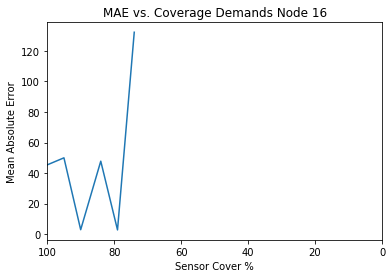

In [30]:
plt.plot(sensors_covered, MAE_average)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/DemandsMAEnode16_10runs.png')
plt.show()

In [21]:
MAE_average = []
sensors_covered = []
n_columns_to_drop = [0, 10, 20, 30, 40, 50, 60, 70, 80]
for n in n_columns_to_drop:
    values = df.values
    values = values.astype('float32')
    reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
    reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
    MAE = []
    #select random columns to drop
    columns_to_drop = random.sample(list(reframed_demand_node16.columns), n)
    # Drop the selected columns from the dataframe
    if reframed_demand_node16.columns[-1] in columns_to_drop:
        columns_to_drop.remove(reframed_demand_node16.columns[-1])
    reframed_demand_node16.drop(columns_to_drop, axis=1, inplace=True)
    print('starting df shape:', reframed_demand_node16.shape)
    for run in range(1,11):
        print(f'This is training run {run} and has the shape: ', reframed_demand_node16.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = reframed_demand_node16.values
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        inv_test_y = concatenate((test_y, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        inv_y_pred = concatenate((y_pred, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
    percentage_list = round(reframed_demand_node16.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    MAE_average.append(MAE_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 45.364094
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 45.364094
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 45.364094
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 45.364094
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 45.364094
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 45.364094
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 45.364094
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 45.364094
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 45.364094
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 45.364094
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 45.31398
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 45.31398
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 45.31398
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 45.31398
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 45.31398
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 45.31398
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 45.31398
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 45.31398
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 45.31398
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 45.31398
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 49.42645
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 49.42645
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 49.42645
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 49.42645
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 49.42645
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 49.42645
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 49.42645
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 49.42645
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 49.42645
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 49.42645
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 46.91177
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 46.91177
This is training run 3 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 46.91177
This is training run 4 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 46.91177
This is training run 5 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 46.91177
This is training run 6 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 46.91177
This is training run 7 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 46.91177
This is training run 8 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 46.91177
This is training run 9 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 46.91177
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 46.91177
starting df shape: (87600, 56)
This is training run 1 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 75.240265
This is training run 2 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 75.240265
This is training run 3 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 75.240265
This is training run 4 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 75.240265
This is training run 5 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 75.240265
This is training run 6 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 75.240265
This is training run 7 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 75.240265
This is training run 8 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 75.240265
This is training run 9 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 75.240265
This is training run 10 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 75.240265
starting df shape: (87600, 47)
This is training run 1 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 4.786814
This is training run 2 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 4.786814
This is training run 3 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 4.786814
This is training run 4 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 4.786814
This is training run 5 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 4.786814
This is training run 6 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 4.786814
This is training run 7 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 4.786814
This is training run 8 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 4.786814
This is training run 9 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 4.786814
This is training run 10 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 4.786814
starting df shape: (87600, 37)
This is training run 1 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 8.659328
This is training run 2 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 8.659328
This is training run 3 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 8.659328
This is training run 4 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 8.659328
This is training run 5 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 8.659328
This is training run 6 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 8.659328
This is training run 7 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 8.659328
This is training run 8 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 8.659328
This is training run 9 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 8.659328
This is training run 10 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 8.659328
starting df shape: (87600, 27)
This is training run 1 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 1.216334
This is training run 2 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 1.216334
This is training run 3 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 1.216334
This is training run 4 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 1.216334
This is training run 5 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 1.216334
This is training run 6 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 1.216334
This is training run 7 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 1.216334
This is training run 8 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 1.216334
This is training run 9 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 1.216334
This is training run 10 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 1.216334
starting df shape: (87600, 17)
This is training run 1 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 10.203991
This is training run 2 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 10.203991
This is training run 3 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 10.203991
This is training run 4 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 10.203991
This is training run 5 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 10.203991
This is training run 6 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 10.203991
This is training run 7 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 10.203991
This is training run 8 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 10.203991
This is training run 9 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 10.203991
This is training run 10 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 10.203991
Length MAE_average:  9
Length sensors_covered:  9


In [22]:
MAE_average

[45.364094,
 45.31398,
 49.42645,
 46.91177,
 75.240265,
 4.786814,
 8.659328,
 1.216334,
 10.203991]

In [23]:
sensors_covered

[100, 90, 79, 69, 58, 49, 39, 28, 18]

In [25]:
MAE_average = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
for n in n_columns_to_drop:
    values = df.values
    values = values.astype('float32')
    reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
    reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
    MAE = []
    #select random columns to drop
    columns_to_drop = random.sample(list(reframed_demand_node16.columns), n)
    # Drop the selected columns from the dataframe
    if reframed_demand_node16.columns[-1] in columns_to_drop:
        columns_to_drop.remove(reframed_demand_node16.columns[-1])
    reframed_demand_node16.drop(columns_to_drop, axis=1, inplace=True)
    print('starting df shape:', reframed_demand_node16.shape)
    for run in range(1,11):
        print(f'This is training run {run} and has the shape: ', reframed_demand_node16.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = reframed_demand_node16.values
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        inv_test_y = concatenate((test_y, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        inv_y_pred = concatenate((y_pred, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
    percentage_list = round(reframed_demand_node16.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    MAE_average.append(MAE_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 45.364094
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 45.364094
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 45.364094
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 45.364094
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 45.364094
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 45.364094
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 45.364094
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 45.364094
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 45.364094
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 45.364094
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 47.01856
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 47.01856
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 47.01856
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 47.01856
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 47.01856
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 47.01856
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 47.01856
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 47.01856
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 47.01856
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 47.01856
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 46.827423
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 46.827423
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 46.827423
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 46.827423
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 46.827423
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 46.827423
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 46.827423
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 46.827423
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 46.827423
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 46.827423
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 47.823517
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 47.823517
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 47.823517
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 47.823517
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 47.823517
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 47.823517
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 47.823517
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 47.823517
This is training run 9 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 47.823517
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 47.823517
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 3.188347
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 3.188347
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 3.188347
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 3.188347
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 3.188347
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 3.188347
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 3.188347
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 3.188347
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 3.188347
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 3.188347
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 130.90436
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 130.90436
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 130.90436
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 130.90436
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 130.90436
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 130.90436
This is training run 7 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 130.90436
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 130.90436
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 130.90436
This is training run 10 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 130.90436
starting df shape: (87600, 67)
This is training run 1 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 118.18964
This is training run 2 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 118.18964
This is training run 3 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 118.18964
This is training run 4 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 118.18964
This is training run 5 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 118.18964
This is training run 6 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 118.18964
This is training run 7 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 118.18964
This is training run 8 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 118.18964
This is training run 9 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 118.18964
This is training run 10 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 118.18964
starting df shape: (87600, 62)
This is training run 1 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 7.486559
This is training run 2 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 7.486559
This is training run 3 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 7.486559
This is training run 4 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 7.486559
This is training run 5 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 7.486559
This is training run 6 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 7.486559
This is training run 7 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 7.486559
This is training run 8 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 7.486559
This is training run 9 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 7.486559
This is training run 10 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 7.486559
starting df shape: (87600, 56)
This is training run 1 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 2.850267
This is training run 2 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 2.850267
This is training run 3 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 2.850267
This is training run 4 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 2.850267
This is training run 5 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 2.850267
This is training run 6 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 2.850267
This is training run 7 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 2.850267
This is training run 8 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 2.850267
This is training run 9 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 2.850267
This is training run 10 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 2.850267
starting df shape: (87600, 52)
This is training run 1 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 6.5760517
This is training run 2 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 6.5760517
This is training run 3 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 6.5760517
This is training run 4 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 6.5760517
This is training run 5 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 6.5760517
This is training run 6 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 6.5760517
This is training run 7 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 6.5760517
This is training run 8 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 6.5760517
This is training run 9 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 6.5760517
This is training run 10 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 6.5760517
starting df shape: (87600, 47)
This is training run 1 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 5.871266
This is training run 2 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 5.871266
This is training run 3 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 5.871266
This is training run 4 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 5.871266
This is training run 5 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 5.871266
This is training run 6 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 5.871266
This is training run 7 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 5.871266
This is training run 8 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 5.871266
This is training run 9 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 5.871266
This is training run 10 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 5.871266
starting df shape: (87600, 41)
This is training run 1 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 162.37688
This is training run 2 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 162.37688
This is training run 3 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 162.37688
This is training run 4 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 162.37688
This is training run 5 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 162.37688
This is training run 6 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 162.37688
This is training run 7 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 162.37688
This is training run 8 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 162.37688
This is training run 9 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 162.37688
This is training run 10 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 162.37688
starting df shape: (87600, 36)
This is training run 1 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 106.098236
This is training run 2 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 106.098236
This is training run 3 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 106.098236
This is training run 4 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 106.098236
This is training run 5 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 106.098236
This is training run 6 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 106.098236
This is training run 7 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 106.098236
This is training run 8 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 106.098236
This is training run 9 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 106.098236
This is training run 10 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 106.098236
starting df shape: (87600, 32)
This is training run 1 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 8.1556015
This is training run 2 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 8.1556015
This is training run 3 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 8.1556015
This is training run 4 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 8.1556015
This is training run 5 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 8.1556015
This is training run 6 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 8.1556015
This is training run 7 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 8.1556015
This is training run 8 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 8.1556015
This is training run 9 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 8.1556015
This is training run 10 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 8.1556015
starting df shape: (87600, 27)
This is training run 1 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 2.7283418
This is training run 2 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 2.7283418
This is training run 3 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 2.7283418
This is training run 4 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 2.7283418
This is training run 5 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 2.7283418
This is training run 6 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 2.7283418
This is training run 7 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 2.7283418
This is training run 8 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 2.7283418
This is training run 9 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 2.7283418
This is training run 10 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 2.7283418
starting df shape: (87600, 22)
This is training run 1 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Mean Absolute Error: 136.76276
This is training run 2 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Mean Absolute Error: 136.76276
This is training run 3 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Mean Absolute Error: 136.76276
This is training run 4 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Mean Absolute Error: 136.76276
This is training run 5 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Mean Absolute Error: 136.76276
This is training run 6 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Mean Absolute Error: 136.76276
This is training run 7 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Mean Absolute Error: 136.76276
This is training run 8 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Mean Absolute Error: 136.76276
This is training run 9 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Mean Absolute Error: 136.76276
This is training run 10 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Mean Absolute Error: 136.76276
Length MAE_average:  16
Length sensors_covered:  16


In [26]:
MAE_average

[45.364094,
 47.01856,
 46.827423,
 47.823517,
 3.188347,
 130.90436,
 118.18964,
 7.486559,
 2.850267,
 6.5760517,
 5.871266,
 162.37688,
 106.098236,
 8.1556015,
 2.7283418,
 136.76276]

In [14]:
MAE_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
for n in n_columns_to_drop:
    MAE = []
    for run in range(1,11):
        values = df.values
        values = values.astype('float32')
        reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
        reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
        #select random columns to drop
        columns_to_drop = random.sample(list(reframed_demand_node16.columns), n)
        # Drop the selected columns from the dataframe
        if reframed_demand_node16.columns[-1] in columns_to_drop:
            columns_to_drop.remove(reframed_demand_node16.columns[-1])
        reframed_demand_node16.drop(columns_to_drop, axis=1, inplace=True)
        print('starting df shape:', reframed_demand_node16.shape)
        print(f'This is training run {run} and has the shape: ', reframed_demand_node16.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = reframed_demand_node16.values
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -reframed_demand_node16.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
    percentage_list = round(reframed_demand_node16.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 45.364094
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 45.364094
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 45.364094
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 45.364094
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 45.364094
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 45.364094
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 45.364094
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 45.364094
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 45.364094
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 45.364094
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 46.367664
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 2 Mean Absolute Error: 46.22527
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 46.19998
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 50.199577
starting df shape: (87600, 91)
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 5 Mean Absolute Error: 49.77516
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 49.57377
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 46.504494
starting df shape: (87600, 91)
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 8 Mean Absolute Error: 47.461376
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 70.96731
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 10 Mean Absolute Error: 46.83624
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 1 Mean Absolute Error: 44.67056
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 47.71262
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 48.607307
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 71.20671
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 5 Mean Absolute Error: 2.9787319
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 125.71847
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 7 Mean Absolute Error: 47.422234
starting df shape: (87600, 86)
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 8 Mean Absolute Error: 47.85979
starting df shape: (87600, 87)
This is training run 9 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 9 Mean Absolute Error: 46.589897
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 47.834774
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 44.446503
starting df shape: (87600, 81)
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 2 Mean Absolute Error: 71.61829
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 3 Mean Absolute Error: 4.659353
starting df shape: (87600, 81)
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 4 Mean Absolute Error: 45.999897
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 45.36719
starting df shape: (87600, 82)
This is training run 6 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 6 Mean Absolute Error: 2.934783
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 7 Mean Absolute Error: 46.210114
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 8 Mean Absolute Error: 43.898346
starting df shape: (87600, 82)
This is training run 9 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 9 Mean Absolute Error: 47.364586
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 47.357986
starting df shape: (87600, 77)
This is training run 1 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 1 Mean Absolute Error: 50.129578
starting df shape: (87600, 77)
This is training run 2 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 2 Mean Absolute Error: 71.69823
starting df shape: (87600, 76)
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 3 Mean Absolute Error: 43.60678
starting df shape: (87600, 77)
This is training run 4 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 4 Mean Absolute Error: 49.64692
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 5 Mean Absolute Error: 45.204674
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 49.79071
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 47.592297
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 74.1005
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 9 Mean Absolute Error: 5.7153826
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 48.16125
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 1 Mean Absolute Error: 47.743755
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 2 Mean Absolute Error: 47.228413
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 78.52864
starting df shape: (87600, 71)
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 4 Mean Absolute Error: 43.945686
starting df shape: (87600, 72)
This is training run 5 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 5 Mean Absolute Error: 128.29106
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 6 Mean Absolute Error: 3.0623567
starting df shape: (87600, 71)
This is training run 7 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 7 Mean Absolute Error: 147.50577
starting df shape: (87600, 71)
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 8 Mean Absolute Error: 76.230896
starting df shape: (87600, 71)
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 9 Mean Absolute Error: 104.43597
starting df shape: (87600, 71)
This is training run 10 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 10 Mean Absolute Error: 50.095787
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 126.74877
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 131.40797
starting df shape: (87600, 66)
This is training run 3 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 3 Mean Absolute Error: 41.070923
starting df shape: (87600, 66)
This is training run 4 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 4 Mean Absolute Error: 2.7923527
starting df shape: (87600, 66)
This is training run 5 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 5 Mean Absolute Error: 43.475716
starting df shape: (87600, 67)
This is training run 6 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 6 Mean Absolute Error: 49.55501
starting df shape: (87600, 66)
This is training run 7 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 7 Mean Absolute Error: 2.8065221
starting df shape: (87600, 66)
This is training run 8 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 8 Mean Absolute Error: 122.342354
starting df shape: (87600, 66)
This is training run 9 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 9 Mean Absolute Error: 2.9464386
starting df shape: (87600, 67)
This is training run 10 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 10 Mean Absolute Error: 127.739555
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 1 Mean Absolute Error: 106.02679
starting df shape: (87600, 61)
This is training run 2 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 2 Mean Absolute Error: 2.8198142
starting df shape: (87600, 62)
This is training run 3 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 3 Mean Absolute Error: 7.826253
starting df shape: (87600, 62)
This is training run 4 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 4 Mean Absolute Error: 130.73865
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 5 Mean Absolute Error: 2.7440624
starting df shape: (87600, 61)
This is training run 6 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 6 Mean Absolute Error: 4.4578648
starting df shape: (87600, 61)
This is training run 7 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 7 Mean Absolute Error: 80.543526
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 8 Mean Absolute Error: 44.92333
starting df shape: (87600, 61)
This is training run 9 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 9 Mean Absolute Error: 1.9584827
starting df shape: (87600, 61)
This is training run 10 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 10 Mean Absolute Error: 49.131344
starting df shape: (87600, 57)
This is training run 1 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 1 Mean Absolute Error: 47.023926
starting df shape: (87600, 56)
This is training run 2 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 2 Mean Absolute Error: 73.47984
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 3 Mean Absolute Error: 7.9554653
starting df shape: (87600, 56)
This is training run 4 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 4 Mean Absolute Error: 45.99479
starting df shape: (87600, 56)
This is training run 5 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 5 Mean Absolute Error: 7.9604506
starting df shape: (87600, 56)
This is training run 6 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 6 Mean Absolute Error: 78.812256
starting df shape: (87600, 56)
This is training run 7 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 7 Mean Absolute Error: 77.16803
starting df shape: (87600, 56)
This is training run 8 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 8 Mean Absolute Error: 0.41536164
starting df shape: (87600, 56)
This is training run 9 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 9 Mean Absolute Error: 4.954027
starting df shape: (87600, 57)
This is training run 10 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 10 Mean Absolute Error: 45.461906
starting df shape: (87600, 52)
This is training run 1 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 1 Mean Absolute Error: 4.6869936
starting df shape: (87600, 51)
This is training run 2 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 2 Mean Absolute Error: 104.72352
starting df shape: (87600, 51)
This is training run 3 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 3 Mean Absolute Error: 4.6577663
starting df shape: (87600, 52)
This is training run 4 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 4 Mean Absolute Error: 4.041578
starting df shape: (87600, 52)
This is training run 5 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 5 Mean Absolute Error: 43.284473
starting df shape: (87600, 52)
This is training run 6 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 6 Mean Absolute Error: 4.3249383
starting df shape: (87600, 51)
This is training run 7 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 7 Mean Absolute Error: 7.4227943
starting df shape: (87600, 52)
This is training run 8 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 8 Mean Absolute Error: 83.32565
starting df shape: (87600, 52)
This is training run 9 and has the shape:  (87600, 52)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 9 Mean Absolute Error: 131.6524
starting df shape: (87600, 51)
This is training run 10 and has the shape:  (87600, 51)
The value of dropped columns is 45


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 10 Mean Absolute Error: 6.3381643
starting df shape: (87600, 47)
This is training run 1 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 1 Mean Absolute Error: 3.3744226
starting df shape: (87600, 46)
This is training run 2 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 2 Mean Absolute Error: 2.5969043
starting df shape: (87600, 47)
This is training run 3 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 3 Mean Absolute Error: 167.24982
starting df shape: (87600, 47)
This is training run 4 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 4 Mean Absolute Error: 141.19713
starting df shape: (87600, 46)
This is training run 5 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 5 Mean Absolute Error: 5.812514
starting df shape: (87600, 46)
This is training run 6 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 6 Mean Absolute Error: 4.868411
starting df shape: (87600, 47)
This is training run 7 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 7 Mean Absolute Error: 0.71124226
starting df shape: (87600, 47)
This is training run 8 and has the shape:  (87600, 47)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 8 Mean Absolute Error: 5.189851
starting df shape: (87600, 46)
This is training run 9 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 9 Mean Absolute Error: 172.55956
starting df shape: (87600, 46)
This is training run 10 and has the shape:  (87600, 46)
The value of dropped columns is 50


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 10 Mean Absolute Error: 159.34793
starting df shape: (87600, 41)
This is training run 1 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 1 Mean Absolute Error: 10.552543
starting df shape: (87600, 42)
This is training run 2 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 2 Mean Absolute Error: 2.6156683
starting df shape: (87600, 42)
This is training run 3 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 3 Mean Absolute Error: 84.6915
starting df shape: (87600, 42)
This is training run 4 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 4 Mean Absolute Error: 7.134794
starting df shape: (87600, 42)
This is training run 5 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 5 Mean Absolute Error: 157.73965
starting df shape: (87600, 41)
This is training run 6 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 6 Mean Absolute Error: 5.123792
starting df shape: (87600, 42)
This is training run 7 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 7 Mean Absolute Error: 162.19043
starting df shape: (87600, 41)
This is training run 8 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 8 Mean Absolute Error: 11.0306835
starting df shape: (87600, 41)
This is training run 9 and has the shape:  (87600, 41)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 9 Mean Absolute Error: 45.50456
starting df shape: (87600, 42)
This is training run 10 and has the shape:  (87600, 42)
The value of dropped columns is 55


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 10 Mean Absolute Error: 123.85668
starting df shape: (87600, 37)
This is training run 1 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 1 Mean Absolute Error: 10.537897
starting df shape: (87600, 36)
This is training run 2 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 2 Mean Absolute Error: 0.45534742
starting df shape: (87600, 36)
This is training run 3 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 3 Mean Absolute Error: 183.94502
starting df shape: (87600, 37)
This is training run 4 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 4 Mean Absolute Error: 47.397102
starting df shape: (87600, 37)
This is training run 5 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 5 Mean Absolute Error: 9.455579
starting df shape: (87600, 37)
This is training run 6 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 6 Mean Absolute Error: 124.26945
starting df shape: (87600, 36)
This is training run 7 and has the shape:  (87600, 36)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 7 Mean Absolute Error: 0.46328583
starting df shape: (87600, 37)
This is training run 8 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 8 Mean Absolute Error: 7.0668435
starting df shape: (87600, 37)
This is training run 9 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 9 Mean Absolute Error: 6.494367
starting df shape: (87600, 37)
This is training run 10 and has the shape:  (87600, 37)
The value of dropped columns is 60


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 10 Mean Absolute Error: 166.09741
starting df shape: (87600, 32)
This is training run 1 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 1 Mean Absolute Error: 11.917764
starting df shape: (87600, 31)
This is training run 2 and has the shape:  (87600, 31)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 2 Mean Absolute Error: 11.929663
starting df shape: (87600, 32)
This is training run 3 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 185.71936
starting df shape: (87600, 32)
This is training run 4 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 4 Mean Absolute Error: 7.4022937
starting df shape: (87600, 31)
This is training run 5 and has the shape:  (87600, 31)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 5 Mean Absolute Error: 131.72552
starting df shape: (87600, 32)
This is training run 6 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 6 Mean Absolute Error: 9.723414
starting df shape: (87600, 32)
This is training run 7 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 7 Mean Absolute Error: 8.913764
starting df shape: (87600, 31)
This is training run 8 and has the shape:  (87600, 31)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 8 Mean Absolute Error: 8.624445
starting df shape: (87600, 32)
This is training run 9 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 9 Mean Absolute Error: 156.38832
starting df shape: (87600, 32)
This is training run 10 and has the shape:  (87600, 32)
The value of dropped columns is 65


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 10 Mean Absolute Error: 0.42308858
starting df shape: (87600, 27)
This is training run 1 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 1 Mean Absolute Error: 47.502106
starting df shape: (87600, 27)
This is training run 2 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 8.378943
starting df shape: (87600, 26)
This is training run 3 and has the shape:  (87600, 26)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 3 Mean Absolute Error: 3.8524458
starting df shape: (87600, 27)
This is training run 4 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 4 Mean Absolute Error: 6.4669523
starting df shape: (87600, 27)
This is training run 5 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 5 Mean Absolute Error: 1.4596665
starting df shape: (87600, 27)
This is training run 6 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 6 Mean Absolute Error: 3.91947
starting df shape: (87600, 26)
This is training run 7 and has the shape:  (87600, 26)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 7 Mean Absolute Error: 11.592557
starting df shape: (87600, 27)
This is training run 8 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 1.6232865
starting df shape: (87600, 27)
This is training run 9 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 9 Mean Absolute Error: 8.758006
starting df shape: (87600, 27)
This is training run 10 and has the shape:  (87600, 27)
The value of dropped columns is 70


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 10 Mean Absolute Error: 10.345763
starting df shape: (87600, 22)
This is training run 1 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 1 Mean Absolute Error: 1.4301028
starting df shape: (87600, 21)
This is training run 2 and has the shape:  (87600, 21)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 2 Mean Absolute Error: 3.5821035
starting df shape: (87600, 22)
This is training run 3 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 3 Mean Absolute Error: 5.552227
starting df shape: (87600, 22)
This is training run 4 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 4 Mean Absolute Error: 8.302045
starting df shape: (87600, 22)
This is training run 5 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 5 Mean Absolute Error: 2.755289
starting df shape: (87600, 22)
This is training run 6 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 11.990716
starting df shape: (87600, 22)
This is training run 7 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 7 Mean Absolute Error: 7.1026382
starting df shape: (87600, 21)
This is training run 8 and has the shape:  (87600, 21)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 8 Mean Absolute Error: 165.18848
starting df shape: (87600, 22)
This is training run 9 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 9 Mean Absolute Error: 1.7818407
starting df shape: (87600, 22)
This is training run 10 and has the shape:  (87600, 22)
The value of dropped columns is 75


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 10 Mean Absolute Error: 11.970348
starting df shape: (87600, 17)
This is training run 1 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 1 Mean Absolute Error: 1.240357
starting df shape: (87600, 17)
This is training run 2 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 11.254494
starting df shape: (87600, 16)
This is training run 3 and has the shape:  (87600, 16)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 3 Mean Absolute Error: 5.39267
starting df shape: (87600, 16)
This is training run 4 and has the shape:  (87600, 16)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 4 Mean Absolute Error: 17.487785
starting df shape: (87600, 17)
This is training run 5 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 5 Mean Absolute Error: 5.6592703
starting df shape: (87600, 17)
This is training run 6 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 6 Mean Absolute Error: 176.96542
starting df shape: (87600, 16)
This is training run 7 and has the shape:  (87600, 16)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 7 Mean Absolute Error: 1.6392695
starting df shape: (87600, 17)
This is training run 8 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 5.3163695
starting df shape: (87600, 17)
This is training run 9 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 9 Mean Absolute Error: 1.7296301
starting df shape: (87600, 17)
This is training run 10 and has the shape:  (87600, 17)
The value of dropped columns is 80


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 10 Mean Absolute Error: 9.86707
starting df shape: (87600, 12)
This is training run 1 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 1 Mean Absolute Error: 0.5594432
starting df shape: (87600, 12)
This is training run 2 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 2 Mean Absolute Error: 1.2208885
starting df shape: (87600, 12)
This is training run 3 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 3 Mean Absolute Error: 0.49773374
starting df shape: (87600, 12)
This is training run 4 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 4 Mean Absolute Error: 8.902493
starting df shape: (87600, 11)
This is training run 5 and has the shape:  (87600, 11)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 11)
y pred shape : (17520, 1)
inv y pred : (17520, 11)
Run 5 Mean Absolute Error: 4.722153
starting df shape: (87600, 12)
This is training run 6 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 6 Mean Absolute Error: 16.696856
starting df shape: (87600, 12)
This is training run 7 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 7 Mean Absolute Error: 10.94904
starting df shape: (87600, 12)
This is training run 8 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 8 Mean Absolute Error: 10.757289
starting df shape: (87600, 12)
This is training run 9 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 9 Mean Absolute Error: 16.934446
starting df shape: (87600, 12)
This is training run 10 and has the shape:  (87600, 12)
The value of dropped columns is 85


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 10 Mean Absolute Error: 15.920867
starting df shape: (87600, 7)
This is training run 1 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 1 Mean Absolute Error: 196.62276
starting df shape: (87600, 7)
This is training run 2 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 2 Mean Absolute Error: 6.9755573
starting df shape: (87600, 7)
This is training run 3 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 3 Mean Absolute Error: 18.004295
starting df shape: (87600, 7)
This is training run 4 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 4 Mean Absolute Error: 11.292999
starting df shape: (87600, 7)
This is training run 5 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 5 Mean Absolute Error: 4.0946803
starting df shape: (87600, 7)
This is training run 6 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 6 Mean Absolute Error: 1.8517781
starting df shape: (87600, 7)
This is training run 7 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 7 Mean Absolute Error: 0.6741052
starting df shape: (87600, 7)
This is training run 8 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 8 Mean Absolute Error: 6.811897
starting df shape: (87600, 7)
This is training run 9 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 9 Mean Absolute Error: 1.7096441
starting df shape: (87600, 7)
This is training run 10 and has the shape:  (87600, 7)
The value of dropped columns is 90


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 10 Mean Absolute Error: 8.327621
starting df shape: (87600, 2)
This is training run 1 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 1 Mean Absolute Error: 1.4878422
starting df shape: (87600, 2)
This is training run 2 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 2 Mean Absolute Error: 8.887719
starting df shape: (87600, 2)
This is training run 3 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 3 Mean Absolute Error: 13.883126
starting df shape: (87600, 2)
This is training run 4 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 4 Mean Absolute Error: 1.1890179
starting df shape: (87600, 2)
This is training run 5 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 5 Mean Absolute Error: 1.1468171
starting df shape: (87600, 2)
This is training run 6 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 6 Mean Absolute Error: 23.971754
starting df shape: (87600, 2)
This is training run 7 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 7 Mean Absolute Error: 18.8384
starting df shape: (87600, 2)
This is training run 8 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 8 Mean Absolute Error: 10.8573265
starting df shape: (87600, 2)
This is training run 9 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 9 Mean Absolute Error: 10.8573265
starting df shape: (87600, 2)
This is training run 10 and has the shape:  (87600, 2)
The value of dropped columns is 95


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 10 Mean Absolute Error: 1.1734107
Length MAE_average:  20
Length sensors_covered:  20
